# Exploration of the GLEAMS model using the WeightWatcher alpha metric

**Author: Austin Keller**

The problem of spectral identification in proteomics is an intensive task requiring several steps of library searching and cross-validation in order to generate confident matches with controlled false-positive error. Each peptide is measured using a mass spectrometer, which creates a spectrum that is then searched against a list of all possible peptides derived from an organism's genomic sequence. This creates a large number of hypotheses which limits statistical power. A newer approach named [GLEAMS by May et al.](https://www.biorxiv.org/content/10.1101/483263v1.abstract) is in development that may make this process much more efficient. Their technique follows [FaceNet's](https://arxiv.org/abs/1503.03832) approach for classification. The aim of GLEAMS is to map mass spectral measurements of peptides to latent space vectors which may then limit the possible candidates to a far smaller pool, and potentially only a single match.

An interesting metric (https://arxiv.org/abs/1810.01075) for evaluating the capacity of deep learning models is [WeightWatcher](https://github.com/CalculatedContent/WeightWatcher). Using intuition from statistical mechanics and Random Matrix Theory, the author hypothesizes that the effectiveness of deep learning can be explained and modeled for a subset of scale invariant problems. WeightWatcher makes empirical phenomological predications about model accuracy without using test set data. This allows for layer-by-layer diagnostic heuristics to be generated using only the final trained model. Here, we simply explore whether the patterns he has observed hold up for the GLEAMS model.

## Table of Contents:
* [Gathering Data](#first-bullet)
* [GLEAMS Analysis](#second-bullet)
* [Imagenet Vgg11 Analysis (a Control)](#third-bullet)
* [Observations](#observations)
* [Conclusion](#conclusion)

## Gathering Data <a class="anchor" id="first-bullet"></a>

In [1]:
# Let's pull the GLEAMS repo to get the pre-trained model
from contextlib import closing
import gzip
import io
import os
import requests
import tarfile


def pull_model():
    url = "https://bitbucket.org/noblelab/gleams/get/0d786d7.tar.gz"
    find_file = "gleams_embedder.model.h5"
    r = requests.get(url)
    with closing(r), tarfile.TarFile(fileobj=gzip.open(io.BytesIO(r.content))) as archive:
        for tarinfo in archive:
            if os.path.basename(tarinfo.name) == find_file:
                f = archive.extractfile(tarinfo.name)
                with open("data/{0:s}".format(find_file), "wb") as out_file:
                    out_file.write(f.read())
                return "data/{0:s}".format(find_file)
                    
model_filename = pull_model()

In [2]:
import keras


embedder_model = keras.models.load_model(model_filename)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
embedder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 47)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 2449)         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           1536        input_10[0][0]                   
__________________________________________________________________________________________________
reshape_3 

## GLEAMS Analysis <a class="anchor" id="second-bullet"></a>

In [16]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import weightwatcher as ww


watcher = ww.WeightWatcher(model=embedder_model)
results = watcher.analyze()

2019-03-25 11:02:32,911 INFO 
WeightWatcher v0.1.1 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) 
[GCC 7.3.0]
numpy       version 1.15.4
tensforflow version 1.12.0
keras       version 2.2.4
2019-03-25 11:02:32,912 INFO Analyzing model 'model_3' with 18 layers
2019-03-25 11:02:32,913 INFO Layer 1: <keras.engine.input_layer.InputLayer object at 0x7f2fec897198>
2019-03-25 11:02:32,914 INFO Layer 1: Skipping (Layer not supported)
2019-03-25 11:02:32,915 INFO Layer 2: <keras.engine.input_layer.InputLayer object at 0x7f2fec897208>
2019-03-25 11:02:32,917 INFO Layer 2: Skipping (Layer not supported)
2019-03-25 11:02:32,918 INFO Layer 3: <keras.engine.input_layer.InputLayer object at 0x7f2fec8974e0>
2019-03-25 11:02:32,918 INFO Layer 3: Skipping (Layer not supported)
2019-03-25 11:02:32,919 INFO Layer 4: <keras.layers.core.Dense object at 0x7f2fe

It appears that we're below the minimum size for each layer. I'd still like to check out the values.

In [7]:
watcher = ww.WeightWatcher(model=embedder_model)
results = watcher.analyze(min_size=32)

2019-03-25 11:04:12,052 INFO 
WeightWatcher v0.1.1 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) 
[GCC 7.3.0]
numpy       version 1.15.4
tensforflow version 1.12.0
keras       version 2.2.4
2019-03-25 11:04:12,058 INFO Analyzing model 'model_3' with 18 layers
2019-03-25 11:04:12,061 INFO Layer 1: <keras.engine.input_layer.InputLayer object at 0x7f2fec897198>
2019-03-25 11:04:12,062 INFO Layer 1: Skipping (Layer not supported)
2019-03-25 11:04:12,063 INFO Layer 2: <keras.engine.input_layer.InputLayer object at 0x7f2fec897208>
2019-03-25 11:04:12,069 INFO Layer 2: Skipping (Layer not supported)
2019-03-25 11:04:12,070 INFO Layer 3: <keras.engine.input_layer.InputLayer object at 0x7f2fec8974e0>
2019-03-25 11:04:12,070 INFO Layer 3: Skipping (Layer not supported)
2019-03-25 11:04:12,071 INFO Layer 4: <keras.layers.core.Dense object at 0x7f2fe

In [9]:
watcher.get_summary()

{'lognorm': 1.268204, 'lognorm_compound': 1.268204003572464}

In [10]:
watcher.print_results()

2019-03-25 11:04:58,385 INFO ### Printing results ###
2019-03-25 11:04:58,387 DEBUG Layer 3: Lognorm: 0.5037112832069397
2019-03-25 11:04:58,388 DEBUG Layer 16: Lognorm: 2.0326967239379883
2019-03-25 11:04:58,394 INFO LogNorm: min: 0.5037112832069397, max: 2.0326967239379883, avg: 1.2682039737701416
2019-03-25 11:04:58,395 INFO LogNorm compound: min: 0.5037112832069397, max: 2.0326967239379883, avg: 1.268204003572464


2019-03-25 11:15:10,573 INFO 
WeightWatcher v0.1.1 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) 
[GCC 7.3.0]
numpy       version 1.15.4
tensforflow version 1.12.0
keras       version 2.2.4
2019-03-25 11:15:10,577 INFO Analyzing model 'model_3' with 18 layers
2019-03-25 11:15:10,581 INFO Layer 1: <keras.engine.input_layer.InputLayer object at 0x7f2fec897198>
2019-03-25 11:15:10,582 INFO Layer 1: Skipping (Layer not supported)
2019-03-25 11:15:10,583 INFO Layer 2: <keras.engine.input_layer.InputLayer object at 0x7f2fec897208>
2019-03-25 11:15:10,583 INFO Layer 2: Skipping (Layer not supported)
2019-03-25 11:15:10,587 INFO Layer 3: <keras.engine.input_layer.InputLayer object at 0x7f2fec8974e0>
2019-03-25 11:15:10,589 INFO Layer 3: Skipping (Layer not supported)
2019-03-25 11:15:10,590 INFO Layer 4: <keras.layers.core.Dense object at 0x7f2fe

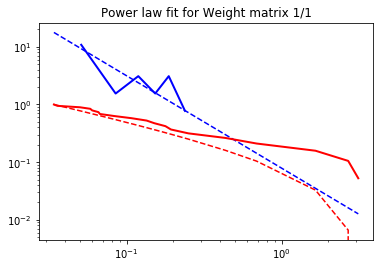

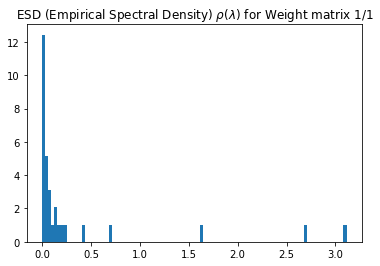

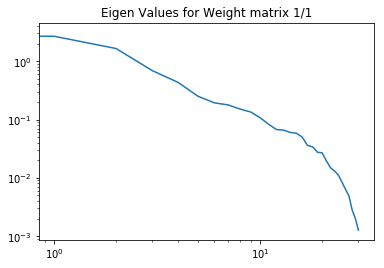

2019-03-25 11:15:13,517 INFO     Weight matrix 1/1 (32,47): Lognorm: 0.5037112832069397
2019-03-25 11:15:13,523 INFO Layer 5: <keras.layers.core.Reshape object at 0x7f2fec897518>
2019-03-25 11:15:13,533 INFO Layer 5: Skipping (Layer not supported)
2019-03-25 11:15:13,537 INFO Layer 6: <keras.layers.core.Reshape object at 0x7f2fec897710>
2019-03-25 11:15:13,545 INFO Layer 6: Skipping (Layer not supported)
2019-03-25 11:15:13,546 INFO Layer 7: <keras.layers.core.Activation object at 0x7f2fec897860>
2019-03-25 11:15:13,547 INFO Layer 7: Skipping (Layer not supported)
2019-03-25 11:15:13,547 INFO Layer 8: <keras.layers.convolutional.Conv1D object at 0x7f2fec8975c0>
2019-03-25 11:15:13,553 INFO Layer 8: Analyzing 1 weight matrices...
2019-03-25 11:15:13,562 INFO     Weight matrix 1/1 (1,30): Skipping: too small (<32)
2019-03-25 11:15:13,563 INFO Layer 9: <keras.layers.convolutional.Conv1D object at 0x7f2fec8975f8>
2019-03-25 11:15:13,564 INFO Layer 9: Analyzing 1 weight matrices...
2019-03-

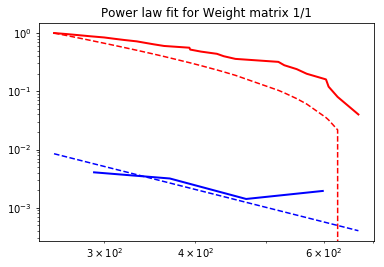

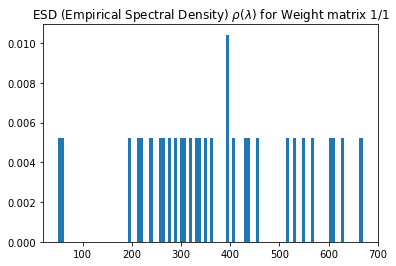

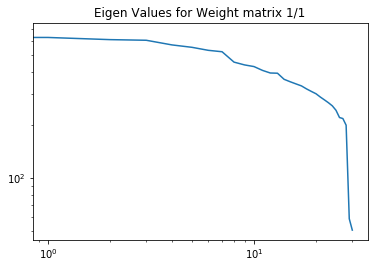

2019-03-25 11:15:16,423 INFO     Weight matrix 1/1 (32,44195): Lognorm: 2.0326967239379883
2019-03-25 11:15:16,432 INFO Layer 18: <keras.layers.core.Activation object at 0x7f2fec837128>
2019-03-25 11:15:16,441 INFO Layer 18: Skipping (Layer not supported)
2019-03-25 11:15:16,444 INFO ### Printing results ###
2019-03-25 11:15:16,445 DEBUG Layer 3: Lognorm: 0.5037112832069397
2019-03-25 11:15:16,446 DEBUG Layer 16: Lognorm: 2.0326967239379883
2019-03-25 11:15:16,454 INFO LogNorm: min: 0.5037112832069397, max: 2.0326967239379883, avg: 1.2682039737701416
2019-03-25 11:15:16,457 INFO LogNorm compound: min: 0.5037112832069397, max: 2.0326967239379883, avg: 1.268204003572464
2019-03-25 11:15:16,458 DEBUG Layer 3: Alpha: 1.6028235390201724
2019-03-25 11:15:16,459 DEBUG Layer 16: Alpha: 3.1674282241442517
2019-03-25 11:15:16,462 INFO Alpha: min: 1.6028235390201724, max: 3.1674282241442517, avg: 2.385125881582212
2019-03-25 11:15:16,462 INFO Alpha compound: min: 1.6028235390201724, max: 3.167428

In [11]:
watcher = ww.WeightWatcher(model=embedder_model)
results = watcher.analyze(min_size=32, compute_alphas=True, plot=True)

In [12]:
watcher.get_summary()

{'lognorm': 1.268204,
 'lognorm_compound': 1.268204003572464,
 'alpha': 2.385125881582212,
 'alpha_compound': 2.385125881582212,
 'alpha_weighted': 4.87018833236766,
 'alpha_weighted_compound': 4.87018833236766}

In [13]:
watcher.print_results()

2019-03-25 11:17:51,756 INFO ### Printing results ###
2019-03-25 11:17:51,761 DEBUG Layer 3: Lognorm: 0.5037112832069397
2019-03-25 11:17:51,763 DEBUG Layer 16: Lognorm: 2.0326967239379883
2019-03-25 11:17:51,763 INFO LogNorm: min: 0.5037112832069397, max: 2.0326967239379883, avg: 1.2682039737701416
2019-03-25 11:17:51,765 INFO LogNorm compound: min: 0.5037112832069397, max: 2.0326967239379883, avg: 1.268204003572464
2019-03-25 11:17:51,766 DEBUG Layer 3: Alpha: 1.6028235390201724
2019-03-25 11:17:51,767 DEBUG Layer 16: Alpha: 3.1674282241442517
2019-03-25 11:17:51,768 INFO Alpha: min: 1.6028235390201724, max: 3.1674282241442517, avg: 2.385125881582212
2019-03-25 11:17:51,769 INFO Alpha compound: min: 1.6028235390201724, max: 3.1674282241442517, avg: 2.385125881582212
2019-03-25 11:17:51,769 DEBUG Layer 3: Alpha Weigthed: 0.790647329161501
2019-03-25 11:17:51,773 DEBUG Layer 16: Alpha Weigthed: 8.949729335573819
2019-03-25 11:17:51,774 INFO Alpha Weighted: min: 0.790647329161501, max: 

## Imagenet Vgg11 Analysis (a Control) <a class="anchor" id="third-bullet"></a>

Now let's compare these results to what we get from a benchmark pre-trained model from the WeightWatcher paper. We want to be able to reproduce their results to sanity check our environment. We also can extract plots from the analysis as another point of reference for comparison beyond just the alpha measure.

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /home/jovyan/.torch/models/vgg11-bbd30ac9.pth
531456000.0 bytes
2019-03-25 11:20:39,167 INFO 
WeightWatcher v0.1.1 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 09:07:38) 
[GCC 7.3.0]
numpy       version 1.15.4
tensforflow version 1.12.0
keras       version 2.2.4
2019-03-25 11:20:39,174 INFO Analyzing model
2019-03-25 11:20:39,174 INFO Layer 1: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3),

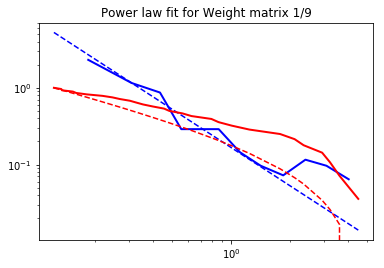

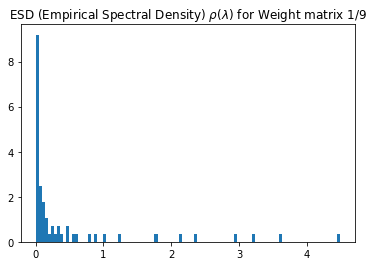

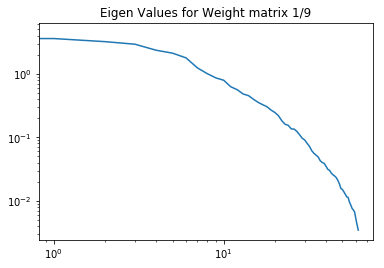

2019-03-25 11:20:42,271 INFO     Weight matrix 1/9 (64,128): Lognorm: 0.7435316443443298
2019-03-25 11:20:42,272 INFO     Weight matrix 2/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:20:42,484 INFO     Weight matrix 2/9 (64,128): Alpha: 1.5729751166883754, Alpha Weighted: 1.1663860197883926, D: 0.1797384784780195


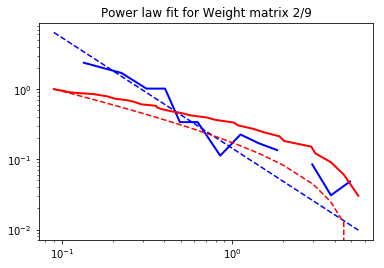

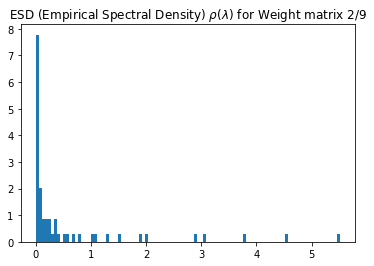

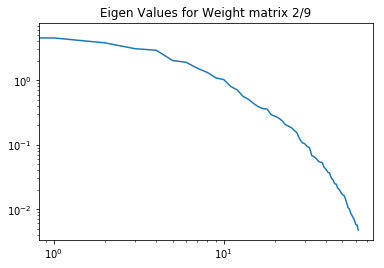

2019-03-25 11:20:45,029 INFO     Weight matrix 2/9 (64,128): Lognorm: 0.7791202068328857
2019-03-25 11:20:45,034 INFO     Weight matrix 3/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:20:45,248 INFO     Weight matrix 3/9 (64,128): Alpha: 1.412103968651306, Alpha Weighted: 0.8954576594850533, D: 0.19428106349877888
2019-03-25 11:20:45,258 INFO     Weight matrix 3/9 (64,128): Alpha 1.412103968651306 is in the danger zone (1.5,3.5)


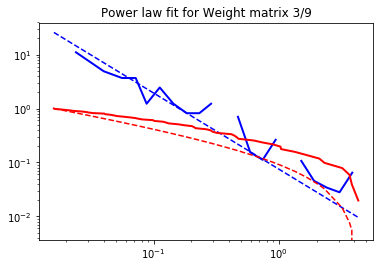

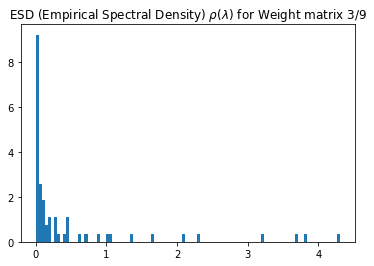

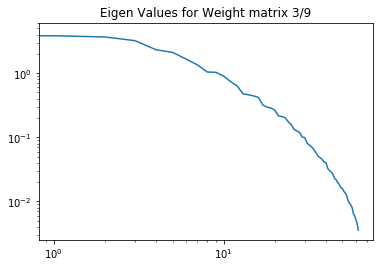

2019-03-25 11:20:48,245 INFO     Weight matrix 3/9 (64,128): Lognorm: 0.7536869049072266
2019-03-25 11:20:48,250 INFO     Weight matrix 4/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:20:48,445 INFO     Weight matrix 4/9 (64,128): Alpha: 1.4345914236582011, Alpha Weighted: 0.9448699281641468, D: 0.18133935525878275
2019-03-25 11:20:48,450 INFO     Weight matrix 4/9 (64,128): Alpha 1.4345914236582011 is in the danger zone (1.5,3.5)


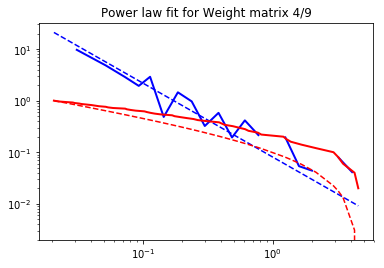

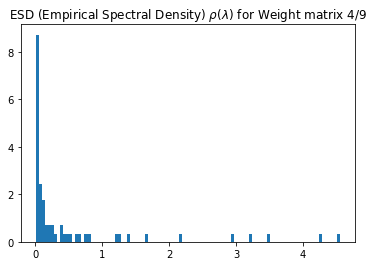

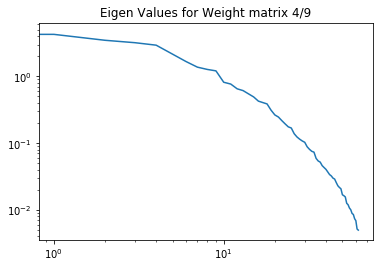

2019-03-25 11:20:51,096 INFO     Weight matrix 4/9 (64,128): Lognorm: 0.7681989669799805
2019-03-25 11:20:51,097 INFO     Weight matrix 5/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:20:51,391 INFO     Weight matrix 5/9 (64,128): Alpha: 1.6184990316129393, Alpha Weighted: 1.5610025865329924, D: 0.1623257720236777


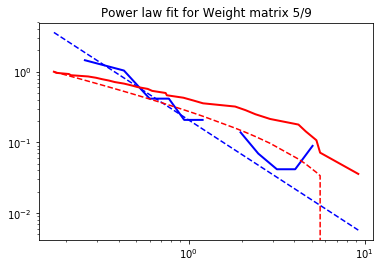

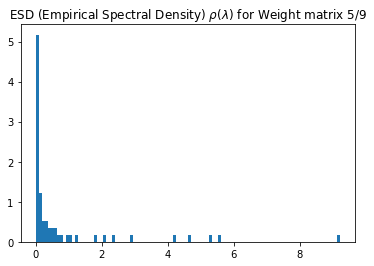

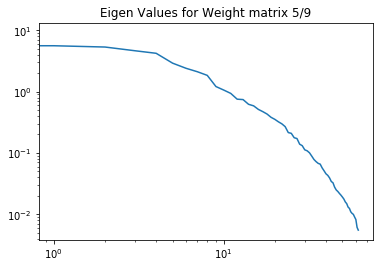

2019-03-25 11:20:56,531 INFO     Weight matrix 5/9 (64,128): Lognorm: 0.8472697734832764
2019-03-25 11:20:56,538 INFO     Weight matrix 6/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:20:56,951 INFO     Weight matrix 6/9 (64,128): Alpha: 1.385485725317857, Alpha Weighted: 1.0132795336617426, D: 0.18905119834469136
2019-03-25 11:20:56,966 INFO     Weight matrix 6/9 (64,128): Alpha 1.385485725317857 is in the danger zone (1.5,3.5)


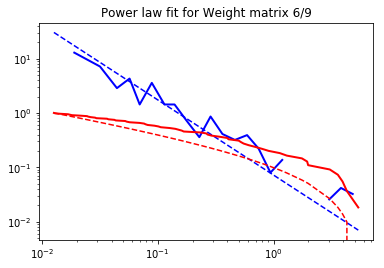

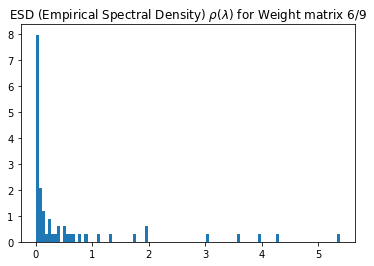

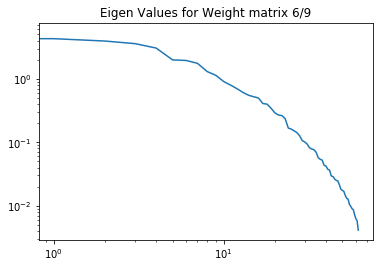

2019-03-25 11:21:02,199 INFO     Weight matrix 6/9 (64,128): Lognorm: 0.7852300405502319
2019-03-25 11:21:02,206 INFO     Weight matrix 7/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:02,613 INFO     Weight matrix 7/9 (64,128): Alpha: 1.569204110278842, Alpha Weighted: 0.9040585066949872, D: 0.18198363897622083


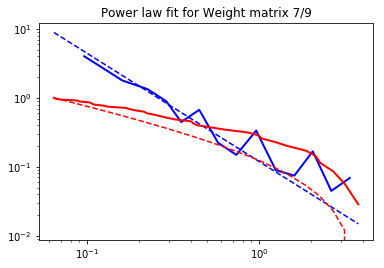

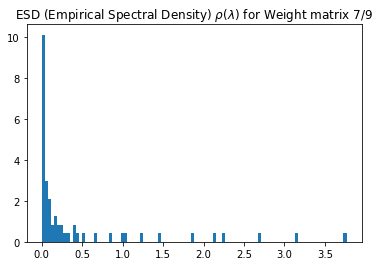

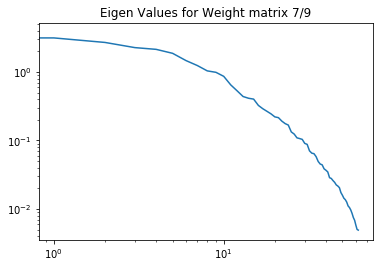

2019-03-25 11:21:07,799 INFO     Weight matrix 7/9 (64,128): Lognorm: 0.7200042009353638
2019-03-25 11:21:07,805 INFO     Weight matrix 8/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:08,260 INFO     Weight matrix 8/9 (64,128): Alpha: 1.4466121653728206, Alpha Weighted: 1.0071456356636947, D: 0.18157984929123344
2019-03-25 11:21:08,274 INFO     Weight matrix 8/9 (64,128): Alpha 1.4466121653728206 is in the danger zone (1.5,3.5)


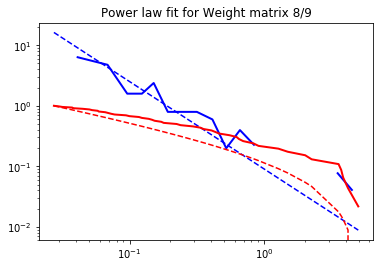

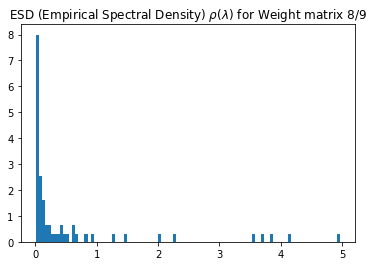

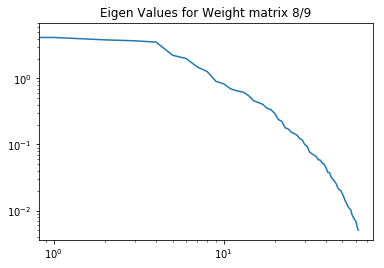

2019-03-25 11:21:13,098 INFO     Weight matrix 8/9 (64,128): Lognorm: 0.780490517616272
2019-03-25 11:21:13,106 INFO     Weight matrix 9/9 (64,128): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:13,570 INFO     Weight matrix 9/9 (64,128): Alpha: 1.6136188763911803, Alpha Weighted: 1.002502618761631, D: 0.1729711978928764


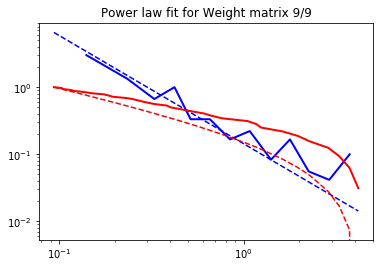

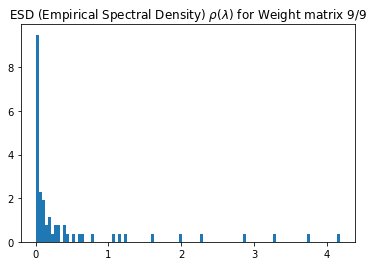

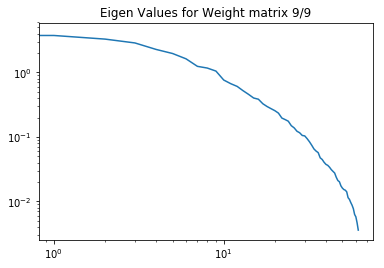

2019-03-25 11:21:18,591 INFO     Weight matrix 9/9 (64,128): Lognorm: 0.7450646758079529
2019-03-25 11:21:18,598 INFO Layer 7: ReLU(inplace)
2019-03-25 11:21:18,598 INFO Layer 7: Skipping (Layer not supported)
2019-03-25 11:21:18,599 INFO Layer 8: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2019-03-25 11:21:18,599 INFO Layer 8: Skipping (Layer not supported)
2019-03-25 11:21:18,600 INFO Layer 9: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2019-03-25 11:21:18,602 INFO Pytorch tensor shape detected: 256x128 (NxM), 3x3 (i,j)
2019-03-25 11:21:18,610 INFO Layer 9: Analyzing 9 weight matrices...
2019-03-25 11:21:18,617 INFO     Weight matrix 1/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
 

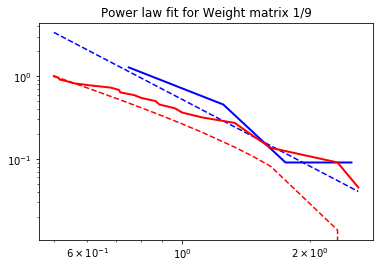

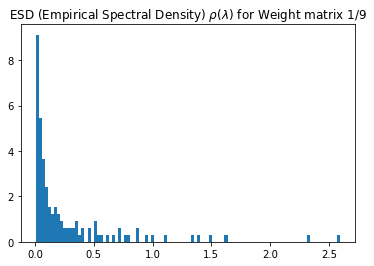

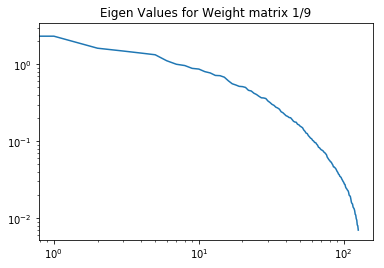

2019-03-25 11:21:24,251 INFO     Weight matrix 1/9 (128,256): Lognorm: 0.7695422768592834
2019-03-25 11:21:24,262 INFO     Weight matrix 2/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:25,301 INFO     Weight matrix 2/9 (128,256): Alpha: 1.6245752499994652, Alpha Weighted: 0.9849720279443598, D: 0.15038346155463478


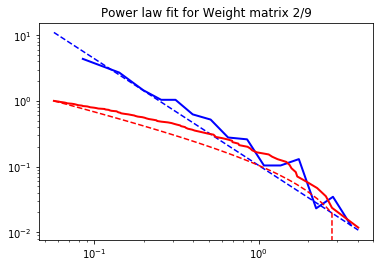

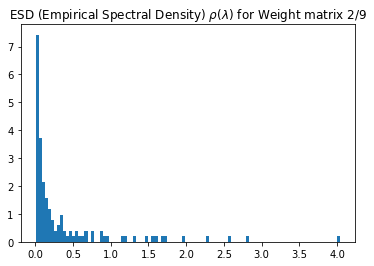

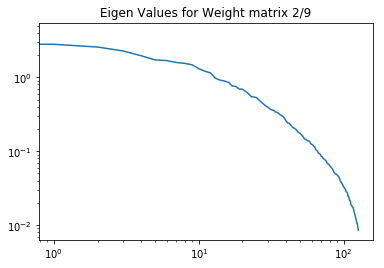

2019-03-25 11:21:30,764 INFO     Weight matrix 2/9 (128,256): Lognorm: 0.8349188566207886
2019-03-25 11:21:30,778 INFO     Weight matrix 3/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:31,832 INFO     Weight matrix 3/9 (128,256): Alpha: 1.7481686159984906, Alpha Weighted: 0.7086750607683288, D: 0.1597620468340939


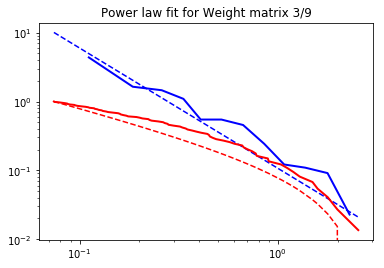

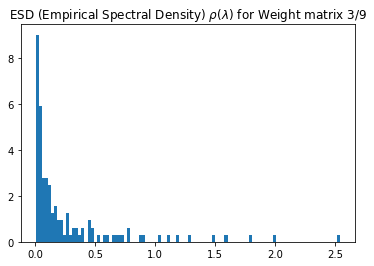

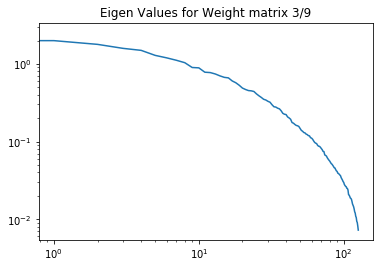

2019-03-25 11:21:36,799 INFO     Weight matrix 3/9 (128,256): Lognorm: 0.7710187435150146
2019-03-25 11:21:36,818 INFO     Weight matrix 4/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:37,850 INFO     Weight matrix 4/9 (128,256): Alpha: 2.576076817052677, Alpha Weighted: 1.6520573142685289, D: 0.13313303017460376


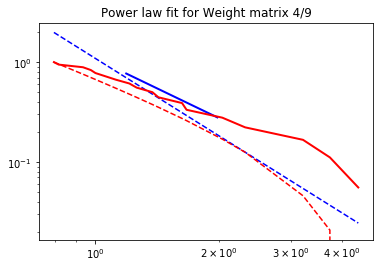

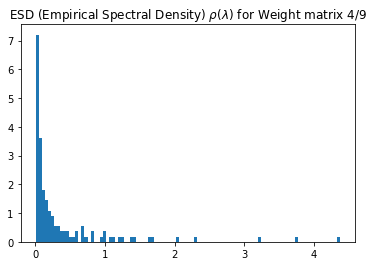

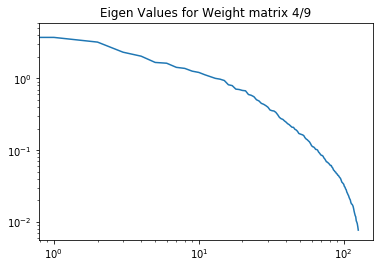

2019-03-25 11:21:43,097 INFO     Weight matrix 4/9 (128,256): Lognorm: 0.8396488428115845
2019-03-25 11:21:43,102 INFO     Weight matrix 5/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:44,183 INFO     Weight matrix 5/9 (128,256): Alpha: 2.5337259159833505, Alpha Weighted: 2.2415207179669423, D: 0.12604014664244678


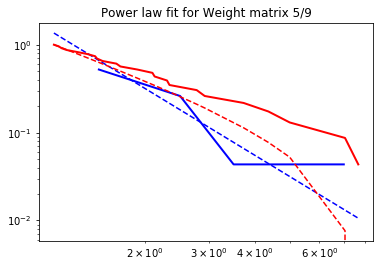

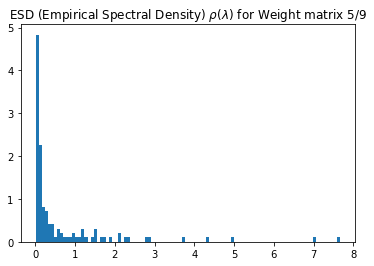

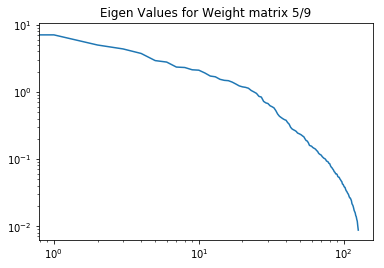

2019-03-25 11:21:49,272 INFO     Weight matrix 5/9 (128,256): Lognorm: 0.9509152770042419
2019-03-25 11:21:49,282 INFO     Weight matrix 6/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:50,279 INFO     Weight matrix 6/9 (128,256): Alpha: 1.6150832073051413, Alpha Weighted: 1.0727972904167644, D: 0.12912558052910023


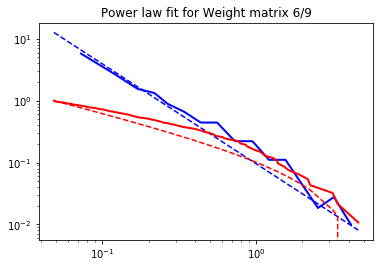

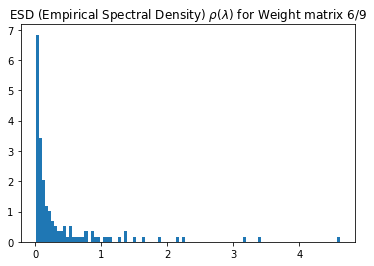

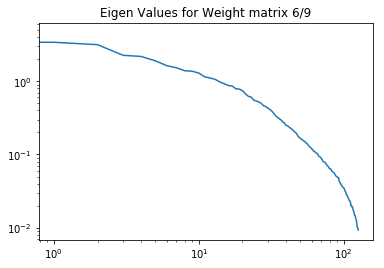

2019-03-25 11:21:55,555 INFO     Weight matrix 6/9 (128,256): Lognorm: 0.8459223508834839
2019-03-25 11:21:55,556 INFO     Weight matrix 7/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:21:56,570 INFO     Weight matrix 7/9 (128,256): Alpha: 1.664928846800635, Alpha Weighted: 0.6363943101948651, D: 0.15493774378379044


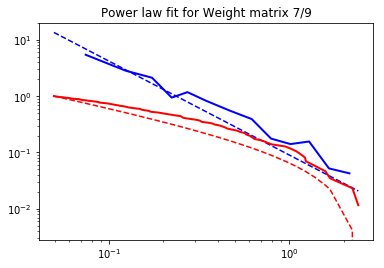

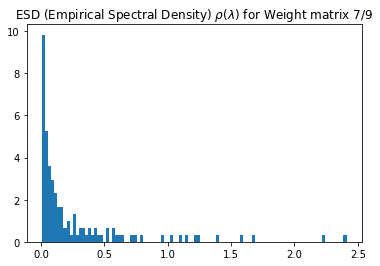

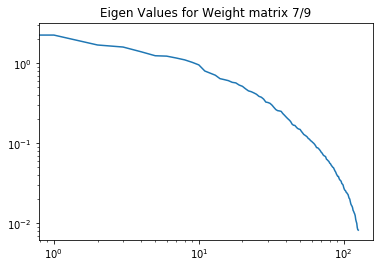

2019-03-25 11:21:59,602 INFO     Weight matrix 7/9 (128,256): Lognorm: 0.769291341304779
2019-03-25 11:21:59,611 INFO     Weight matrix 8/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:00,042 INFO     Weight matrix 8/9 (128,256): Alpha: 1.6911651907401135, Alpha Weighted: 1.0206923968841775, D: 0.13113822217766913


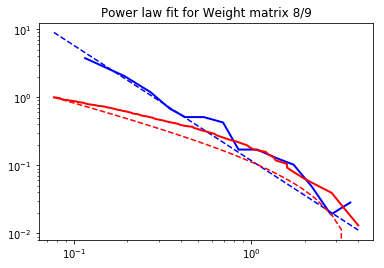

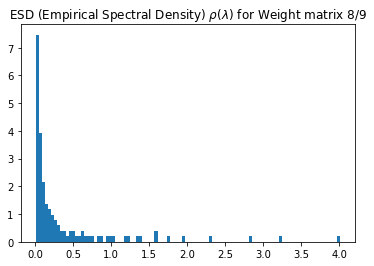

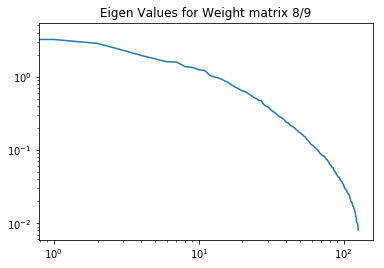

2019-03-25 11:22:02,294 INFO     Weight matrix 8/9 (128,256): Lognorm: 0.8332030773162842
2019-03-25 11:22:02,302 INFO     Weight matrix 9/9 (128,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:02,754 INFO     Weight matrix 9/9 (128,256): Alpha: 2.0503666180672493, Alpha Weighted: 0.8569671743479883, D: 0.14425810588797405


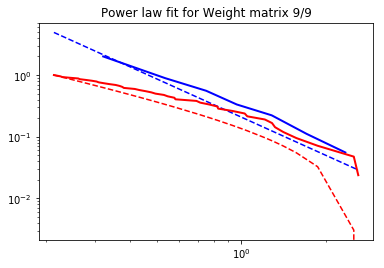

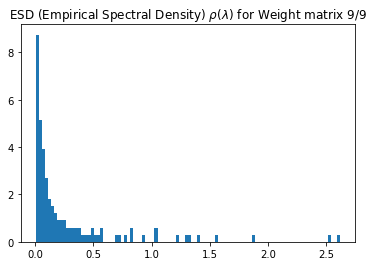

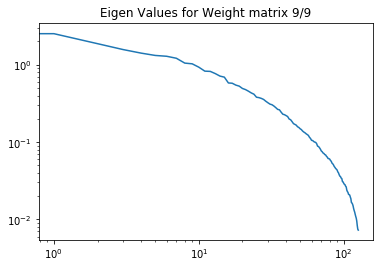

2019-03-25 11:22:04,708 INFO     Weight matrix 9/9 (128,256): Lognorm: 0.7771601676940918
2019-03-25 11:22:04,715 INFO Layer 10: ReLU(inplace)
2019-03-25 11:22:04,716 INFO Layer 10: Skipping (Layer not supported)
2019-03-25 11:22:04,722 INFO Layer 11: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2019-03-25 11:22:04,730 INFO Pytorch tensor shape detected: 256x256 (NxM), 3x3 (i,j)
2019-03-25 11:22:04,737 INFO Layer 11: Analyzing 9 weight matrices...
2019-03-25 11:22:04,739 INFO     Weight matrix 1/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:05,941 INFO     Weight matrix 1/9 (256,256): Alpha: 2.2103687325482904, Alpha Weighted: 0.872120999568611, D: 0.12885

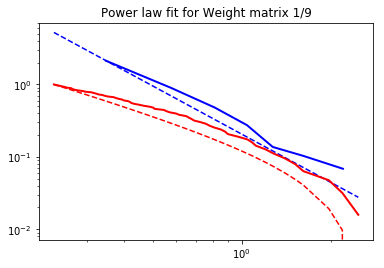

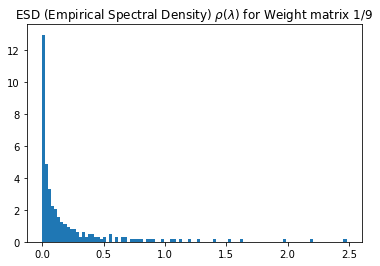

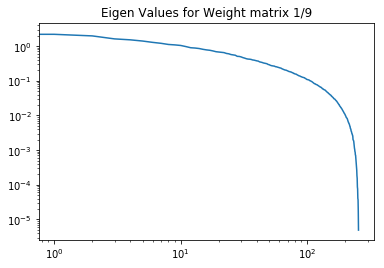

2019-03-25 11:22:08,292 INFO     Weight matrix 1/9 (256,256): Lognorm: 0.8579453229904175
2019-03-25 11:22:08,303 INFO     Weight matrix 2/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:09,462 INFO     Weight matrix 2/9 (256,256): Alpha: 2.025263743349626, Alpha Weighted: 1.0256382022104313, D: 0.12252803705604653


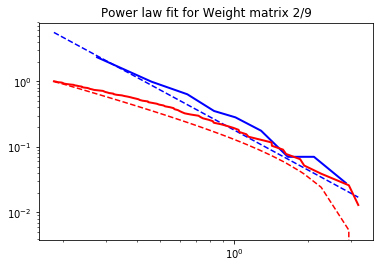

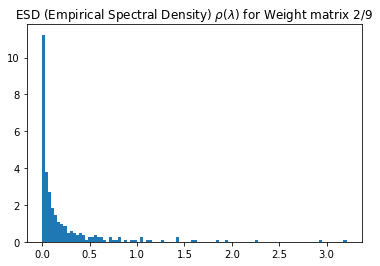

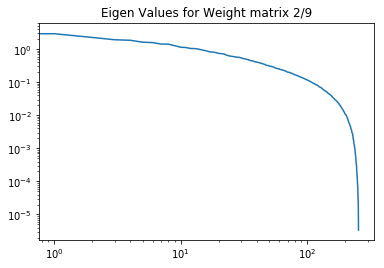

2019-03-25 11:22:11,739 INFO     Weight matrix 2/9 (256,256): Lognorm: 0.8855762481689453
2019-03-25 11:22:11,746 INFO     Weight matrix 3/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:12,891 INFO     Weight matrix 3/9 (256,256): Alpha: 2.0484483120427415, Alpha Weighted: 0.8159194733749071, D: 0.12204167440971098


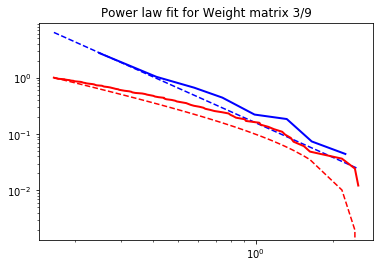

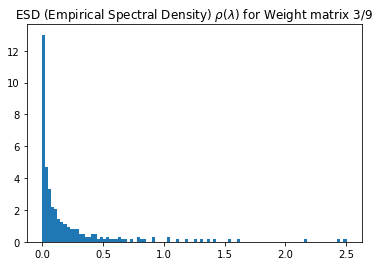

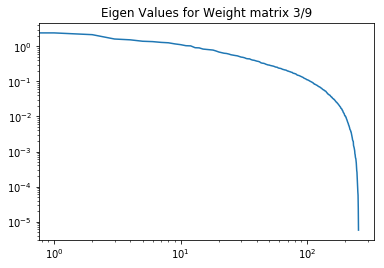

2019-03-25 11:22:15,462 INFO     Weight matrix 3/9 (256,256): Lognorm: 0.8663251996040344
2019-03-25 11:22:15,464 INFO     Weight matrix 4/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:16,649 INFO     Weight matrix 4/9 (256,256): Alpha: 2.658269905782344, Alpha Weighted: 1.321143292206357, D: 0.12169859235778707


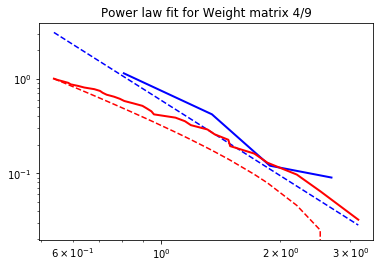

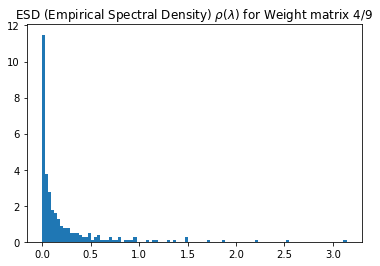

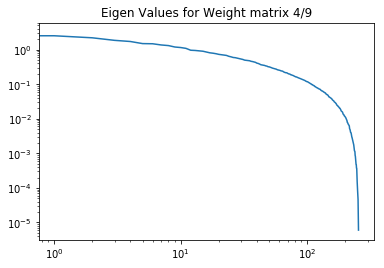

2019-03-25 11:22:19,310 INFO     Weight matrix 4/9 (256,256): Lognorm: 0.8791446685791016
2019-03-25 11:22:19,318 INFO     Weight matrix 5/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:20,496 INFO     Weight matrix 5/9 (256,256): Alpha: 1.800453616605746, Alpha Weighted: 1.3681391151468518, D: 0.11590103717645117


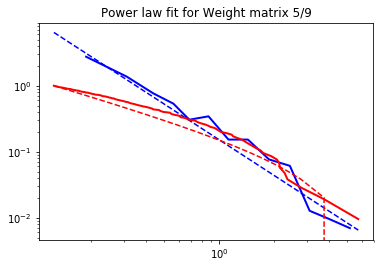

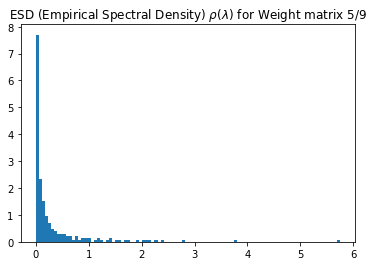

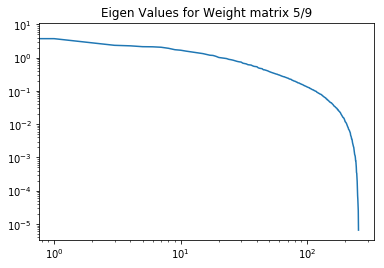

2019-03-25 11:22:23,259 INFO     Weight matrix 5/9 (256,256): Lognorm: 0.9453065991401672
2019-03-25 11:22:23,268 INFO     Weight matrix 6/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:24,448 INFO     Weight matrix 6/9 (256,256): Alpha: 2.0425168738784207, Alpha Weighted: 1.1107904276344067, D: 0.12374553175870884


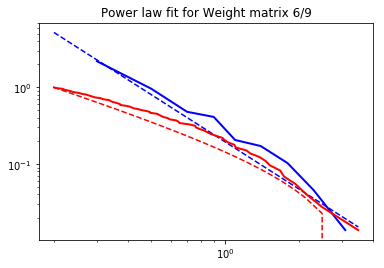

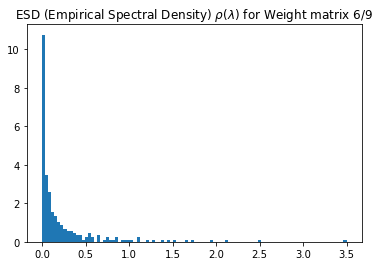

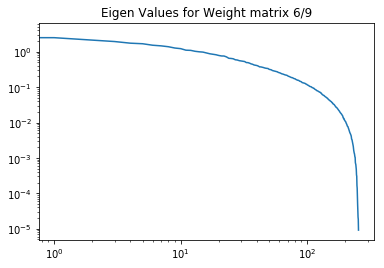

2019-03-25 11:22:26,726 INFO     Weight matrix 6/9 (256,256): Lognorm: 0.886420488357544
2019-03-25 11:22:26,733 INFO     Weight matrix 7/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:27,883 INFO     Weight matrix 7/9 (256,256): Alpha: 2.604095292562791, Alpha Weighted: 1.0384139045541538, D: 0.12428426615103083


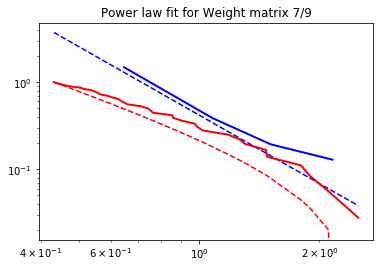

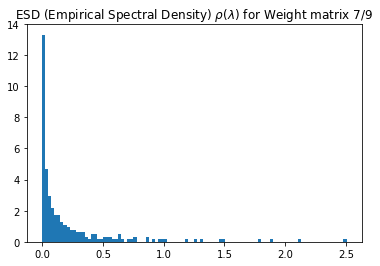

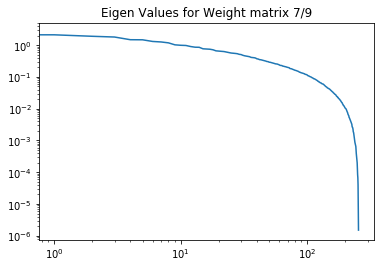

2019-03-25 11:22:30,523 INFO     Weight matrix 7/9 (256,256): Lognorm: 0.8589674234390259
2019-03-25 11:22:30,537 INFO     Weight matrix 8/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:31,694 INFO     Weight matrix 8/9 (256,256): Alpha: 1.97442673277421, Alpha Weighted: 0.9784464808534951, D: 0.12141254733175821


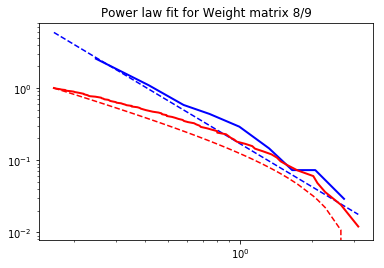

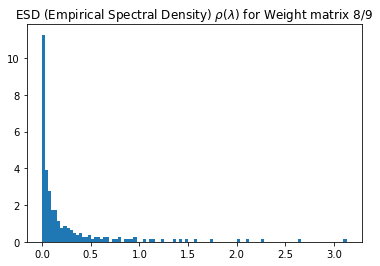

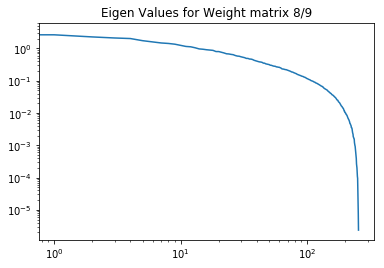

2019-03-25 11:22:34,170 INFO     Weight matrix 8/9 (256,256): Lognorm: 0.8895105123519897
2019-03-25 11:22:34,172 INFO     Weight matrix 9/9 (256,256): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:35,323 INFO     Weight matrix 9/9 (256,256): Alpha: 2.073195529958781, Alpha Weighted: 0.8033689274604342, D: 0.13215309702688627


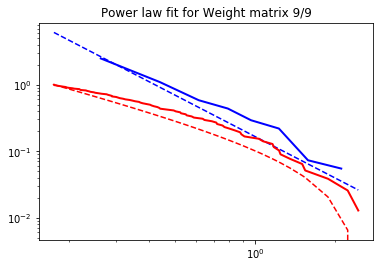

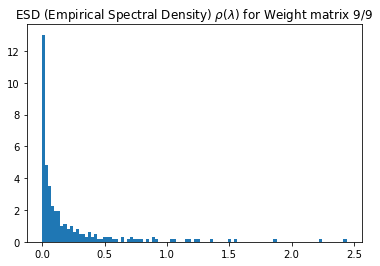

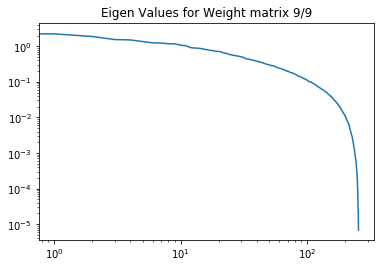

2019-03-25 11:22:37,723 INFO     Weight matrix 9/9 (256,256): Lognorm: 0.8611611127853394
2019-03-25 11:22:37,737 INFO Layer 12: ReLU(inplace)
2019-03-25 11:22:37,739 INFO Layer 12: Skipping (Layer not supported)
2019-03-25 11:22:37,740 INFO Layer 13: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2019-03-25 11:22:37,743 INFO Layer 13: Skipping (Layer not supported)
2019-03-25 11:22:37,745 INFO Layer 14: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2019-03-25 11:22:37,763 INFO Pytorch tensor shape detected: 512x256 (NxM), 3x3 (i,j)
2019-03-25 11:22:37,770 INFO Layer 14: Analyzing 9 weight matrices...
2019-03-25 11:22:37,772 INFO     Weight matrix 1/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_d

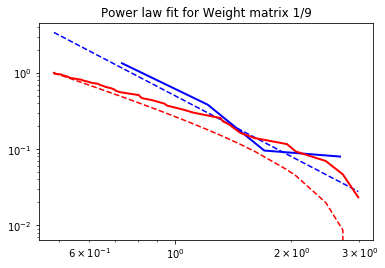

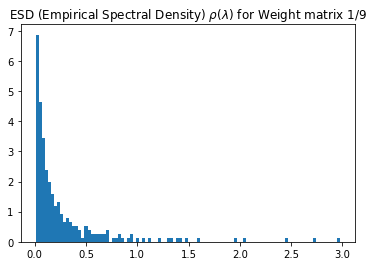

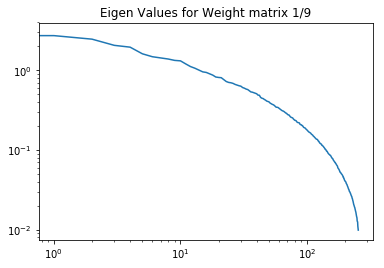

2019-03-25 11:22:41,327 INFO     Weight matrix 1/9 (256,512): Lognorm: 0.9264130592346191
2019-03-25 11:22:41,334 INFO     Weight matrix 2/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:42,528 INFO     Weight matrix 2/9 (256,512): Alpha: 2.168114248751584, Alpha Weighted: 1.2167367195324768, D: 0.12372011866166238


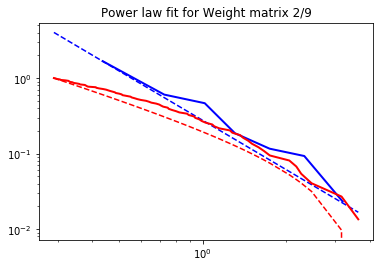

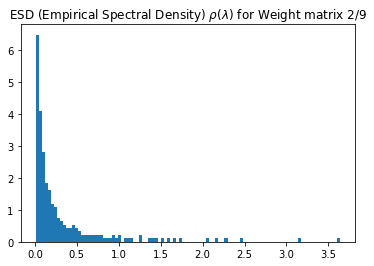

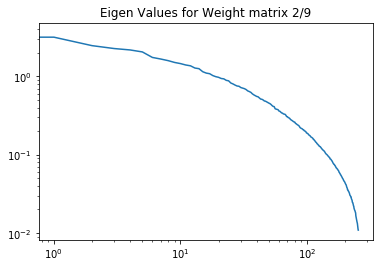

2019-03-25 11:22:44,539 INFO     Weight matrix 2/9 (256,512): Lognorm: 0.9532338976860046
2019-03-25 11:22:44,547 INFO     Weight matrix 3/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:45,701 INFO     Weight matrix 3/9 (256,512): Alpha: 2.689084608232463, Alpha Weighted: 1.2802727752480427, D: 0.09975446705579122


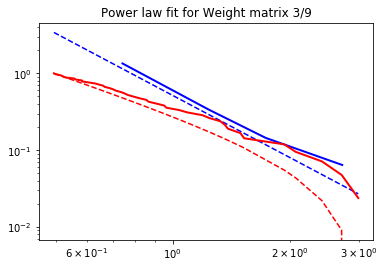

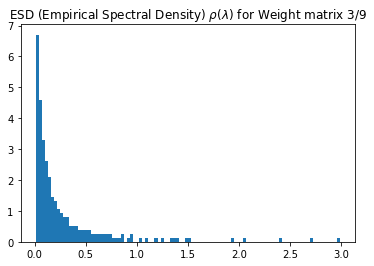

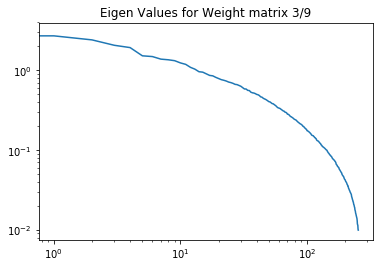

2019-03-25 11:22:48,132 INFO     Weight matrix 3/9 (256,512): Lognorm: 0.9262917041778564
2019-03-25 11:22:48,139 INFO     Weight matrix 4/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:49,320 INFO     Weight matrix 4/9 (256,512): Alpha: 2.055718790110234, Alpha Weighted: 1.2611997723137784, D: 0.11025213782616616


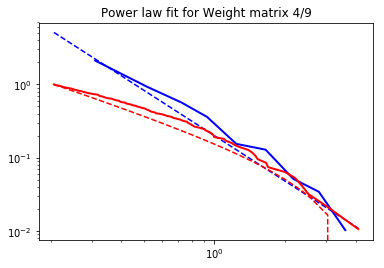

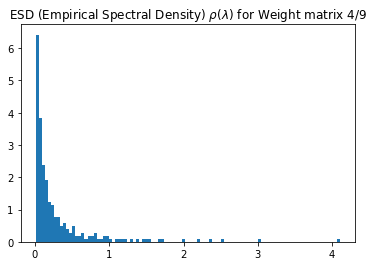

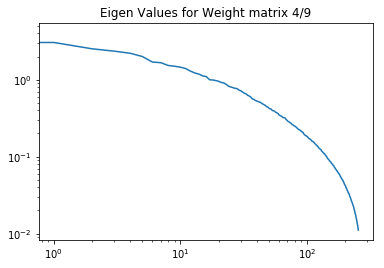

2019-03-25 11:22:51,357 INFO     Weight matrix 4/9 (256,512): Lognorm: 0.9493744969367981
2019-03-25 11:22:51,364 INFO     Weight matrix 5/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:52,522 INFO     Weight matrix 5/9 (256,512): Alpha: 3.824148894291921, Alpha Weighted: 3.2637533816718904, D: 0.09906491795553951
2019-03-25 11:22:52,524 INFO     Weight matrix 5/9 (256,512): Alpha 3.824148894291921 is in the danger zone (1.5,3.5)


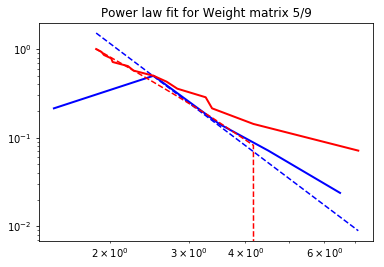

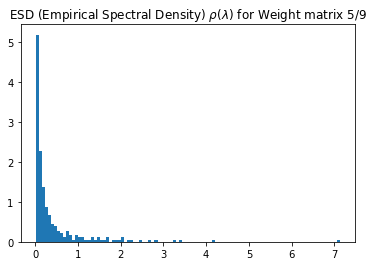

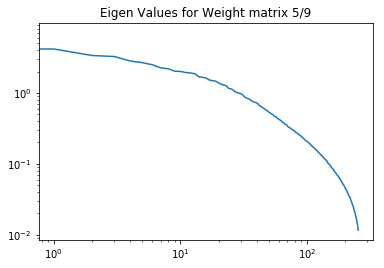

2019-03-25 11:22:54,792 INFO     Weight matrix 5/9 (256,512): Lognorm: 1.0106232166290283
2019-03-25 11:22:54,801 INFO     Weight matrix 6/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:55,980 INFO     Weight matrix 6/9 (256,512): Alpha: 2.841660813744557, Alpha Weighted: 1.7285456042766218, D: 0.10146021239855946


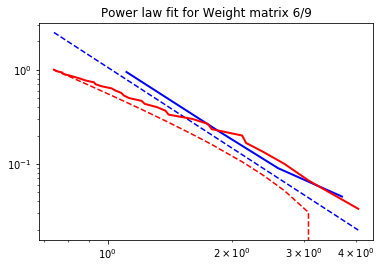

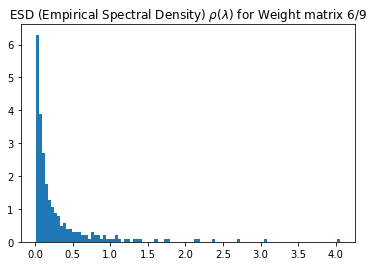

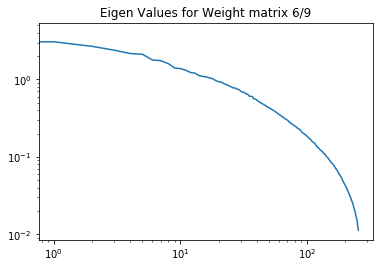

2019-03-25 11:22:58,144 INFO     Weight matrix 6/9 (256,512): Lognorm: 0.9507067203521729
2019-03-25 11:22:58,155 INFO     Weight matrix 7/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:22:59,419 INFO     Weight matrix 7/9 (256,512): Alpha: 2.54266038339117, Alpha Weighted: 1.192761981969006, D: 0.11033069735616413


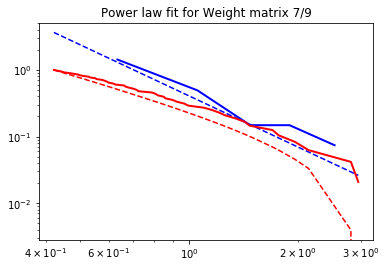

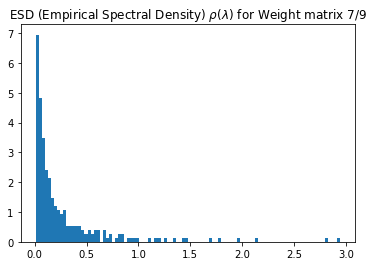

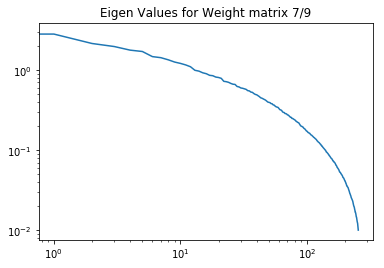

2019-03-25 11:23:01,926 INFO     Weight matrix 7/9 (256,512): Lognorm: 0.9216505885124207
2019-03-25 11:23:01,931 INFO     Weight matrix 8/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:03,198 INFO     Weight matrix 8/9 (256,512): Alpha: 2.8994887058332757, Alpha Weighted: 1.6334752433689423, D: 0.11620831205802584


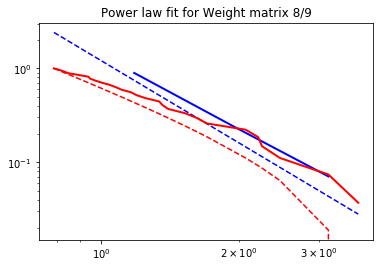

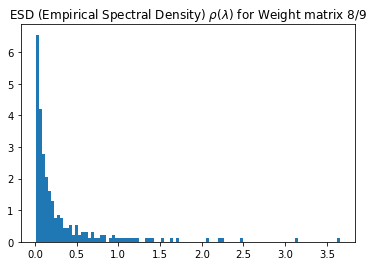

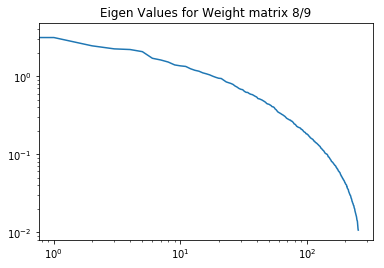

2019-03-25 11:23:05,287 INFO     Weight matrix 8/9 (256,512): Lognorm: 0.9460031390190125
2019-03-25 11:23:05,295 INFO     Weight matrix 9/9 (256,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:06,602 INFO     Weight matrix 9/9 (256,512): Alpha: 2.267161367593299, Alpha Weighted: 1.1108178767321766, D: 0.11398775180612103


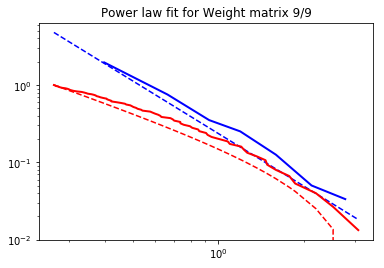

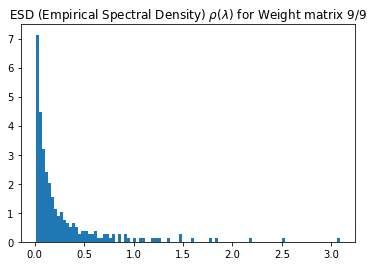

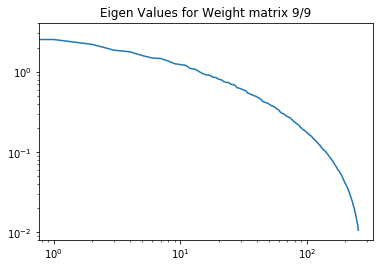

2019-03-25 11:23:08,914 INFO     Weight matrix 9/9 (256,512): Lognorm: 0.922294020652771
2019-03-25 11:23:08,923 INFO Layer 15: ReLU(inplace)
2019-03-25 11:23:08,924 INFO Layer 15: Skipping (Layer not supported)
2019-03-25 11:23:08,926 INFO Layer 16: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2019-03-25 11:23:08,946 INFO Pytorch tensor shape detected: 512x512 (NxM), 3x3 (i,j)
2019-03-25 11:23:08,954 INFO Layer 16: Analyzing 9 weight matrices...
2019-03-25 11:23:08,956 INFO     Weight matrix 1/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:12,820 INFO     Weight matrix 1/9 (512,512): Alpha: 3.149647033571573, Alpha Weighted: 2.0280548371235207, D: 0.051210

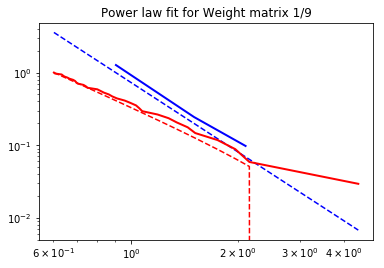

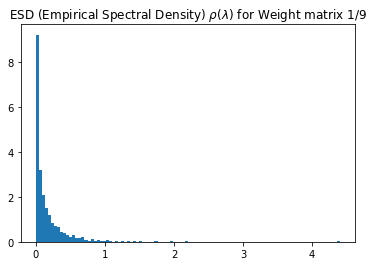

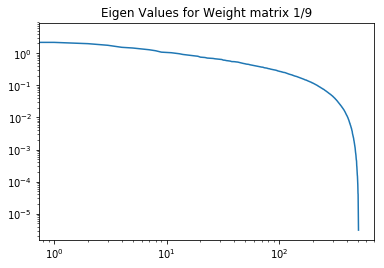

2019-03-25 11:23:15,260 INFO     Weight matrix 1/9 (512,512): Lognorm: 0.9826977849006653
2019-03-25 11:23:15,267 INFO     Weight matrix 2/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:18,545 INFO     Weight matrix 2/9 (512,512): Alpha: 3.517967155934014, Alpha Weighted: 2.726138029282473, D: 0.06635118810764051
2019-03-25 11:23:18,547 INFO     Weight matrix 2/9 (512,512): Alpha 3.517967155934014 is in the danger zone (1.5,3.5)


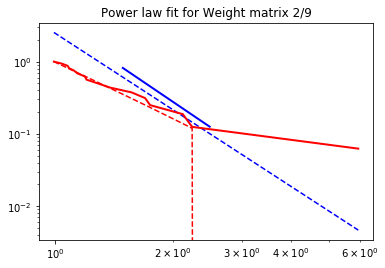

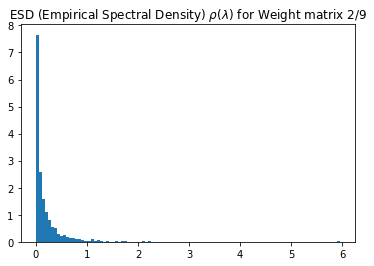

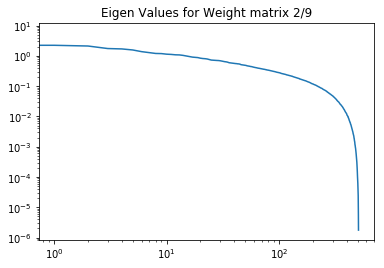

2019-03-25 11:23:21,353 INFO     Weight matrix 2/9 (512,512): Lognorm: 0.9950790405273438
2019-03-25 11:23:21,356 INFO     Weight matrix 3/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:24,751 INFO     Weight matrix 3/9 (512,512): Alpha: 3.147036809411206, Alpha Weighted: 1.9897806474585367, D: 0.05371068656383121


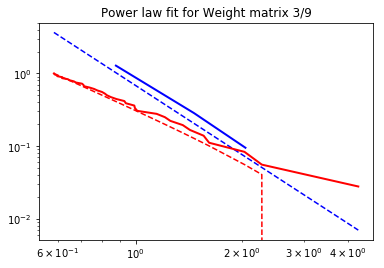

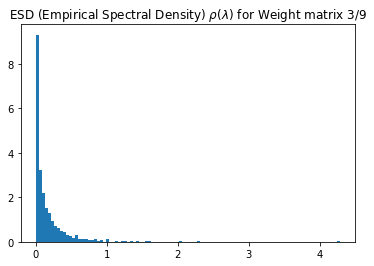

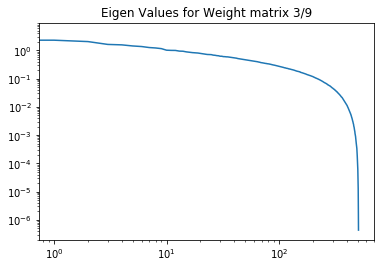

2019-03-25 11:23:27,191 INFO     Weight matrix 3/9 (512,512): Lognorm: 0.9823006987571716
2019-03-25 11:23:27,195 INFO     Weight matrix 4/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:30,407 INFO     Weight matrix 4/9 (512,512): Alpha: 2.7469929287685853, Alpha Weighted: 2.139472080808277, D: 0.05741480574167257


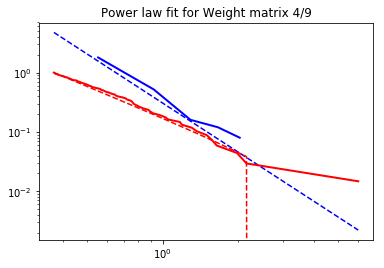

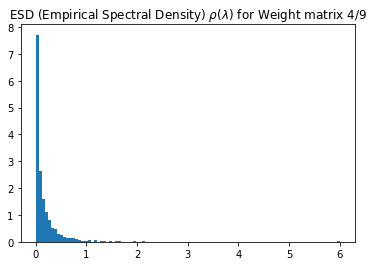

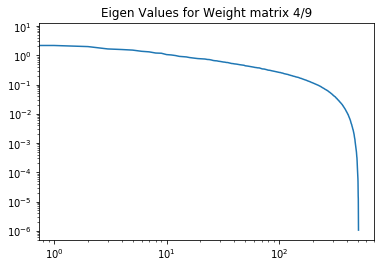

2019-03-25 11:23:33,079 INFO     Weight matrix 4/9 (512,512): Lognorm: 0.9806456565856934
2019-03-25 11:23:33,090 INFO     Weight matrix 5/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:36,461 INFO     Weight matrix 5/9 (512,512): Alpha: 2.407422856462671, Alpha Weighted: 2.3368162643907873, D: 0.06230377161462569


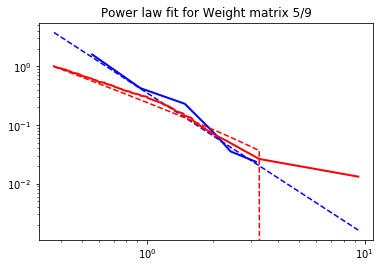

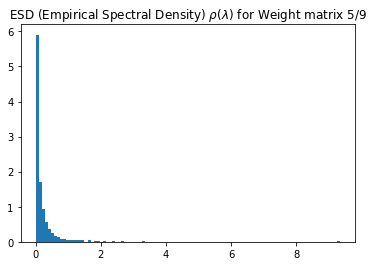

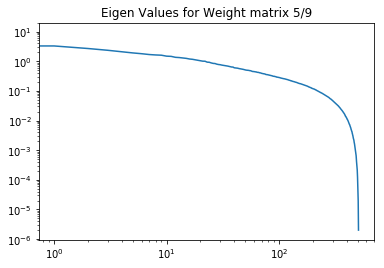

2019-03-25 11:23:39,077 INFO     Weight matrix 5/9 (512,512): Lognorm: 1.0240429639816284
2019-03-25 11:23:39,080 INFO     Weight matrix 6/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:42,366 INFO     Weight matrix 6/9 (512,512): Alpha: 3.302656899528466, Alpha Weighted: 2.529941986827904, D: 0.050069665630552485


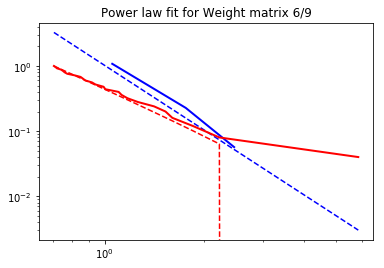

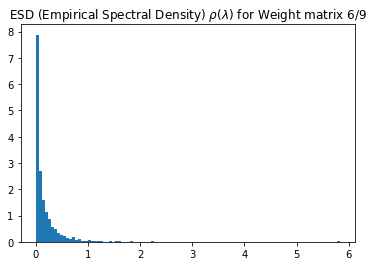

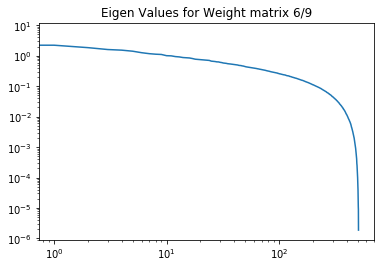

2019-03-25 11:23:45,052 INFO     Weight matrix 6/9 (512,512): Lognorm: 0.9784255623817444
2019-03-25 11:23:45,060 INFO     Weight matrix 7/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:48,446 INFO     Weight matrix 7/9 (512,512): Alpha: 3.1959302636304847, Alpha Weighted: 1.9390560510553845, D: 0.052176975928250546


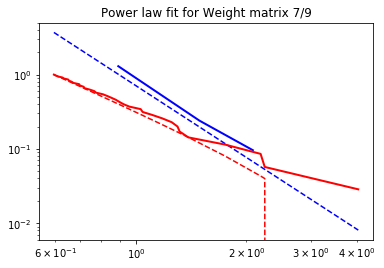

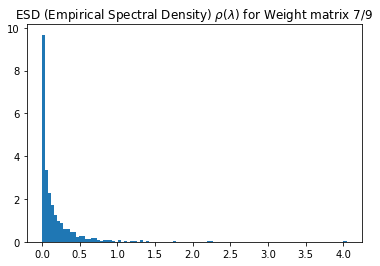

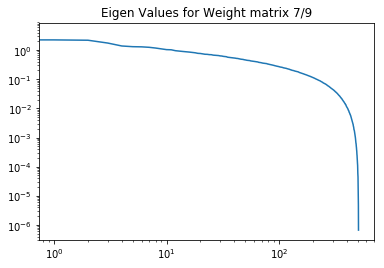

2019-03-25 11:23:51,297 INFO     Weight matrix 7/9 (512,512): Lognorm: 0.9802640676498413
2019-03-25 11:23:51,304 INFO     Weight matrix 8/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:53,319 INFO     Weight matrix 8/9 (512,512): Alpha: 3.3540208882156177, Alpha Weighted: 2.6749306643672965, D: 0.046509284290875086


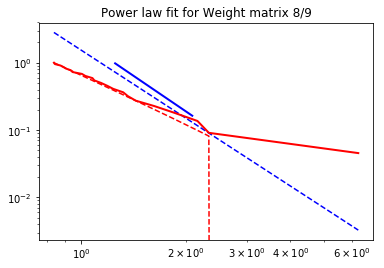

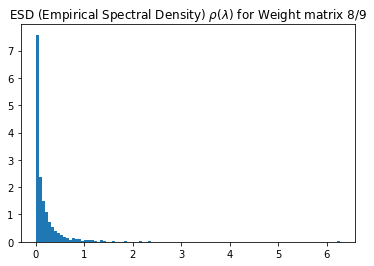

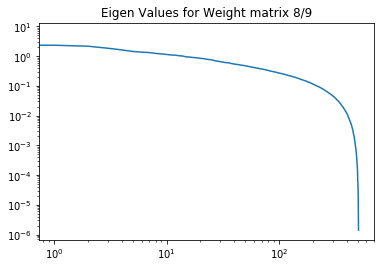

2019-03-25 11:23:54,667 INFO     Weight matrix 8/9 (512,512): Lognorm: 0.9925370812416077
2019-03-25 11:23:54,669 INFO     Weight matrix 9/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:23:56,431 INFO     Weight matrix 9/9 (512,512): Alpha: 2.967193831487105, Alpha Weighted: 1.8252364919054012, D: 0.06097187356181635


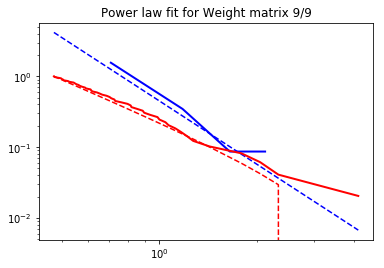

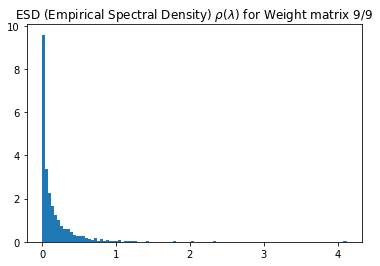

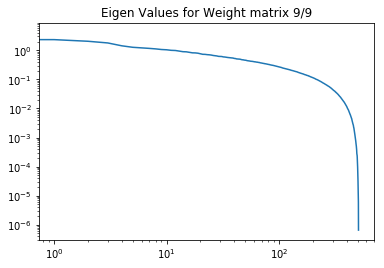

2019-03-25 11:23:57,704 INFO     Weight matrix 9/9 (512,512): Lognorm: 0.9784339666366577
2019-03-25 11:23:57,707 INFO Layer 17: ReLU(inplace)
2019-03-25 11:23:57,709 INFO Layer 17: Skipping (Layer not supported)
2019-03-25 11:23:57,711 INFO Layer 18: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2019-03-25 11:23:57,714 INFO Layer 18: Skipping (Layer not supported)
2019-03-25 11:23:57,715 INFO Layer 19: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2019-03-25 11:23:57,724 INFO Pytorch tensor shape detected: 512x512 (NxM), 3x3 (i,j)
2019-03-25 11:23:57,727 INFO Layer 19: Analyzing 9 weight matrices...
2019-03-25 11:23:57,728 INFO     Weight matrix 1/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_d

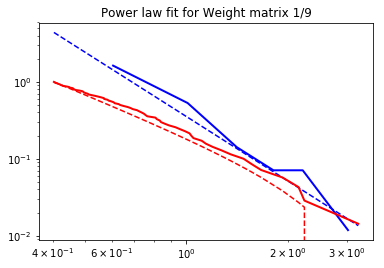

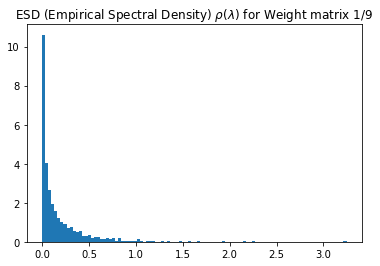

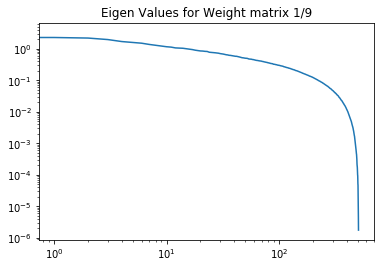

2019-03-25 11:24:01,023 INFO     Weight matrix 1/9 (512,512): Lognorm: 0.9942262768745422
2019-03-25 11:24:01,026 INFO     Weight matrix 2/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:02,717 INFO     Weight matrix 2/9 (512,512): Alpha: 3.650770349320823, Alpha Weighted: 2.226927750353644, D: 0.07941572299862021
2019-03-25 11:24:02,724 INFO     Weight matrix 2/9 (512,512): Alpha 3.650770349320823 is in the danger zone (1.5,3.5)


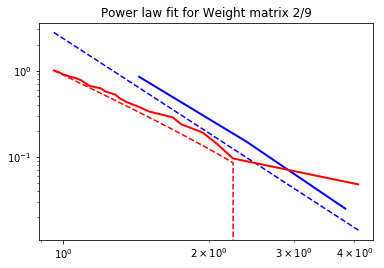

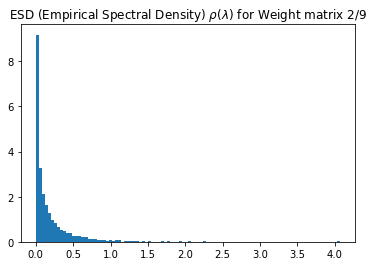

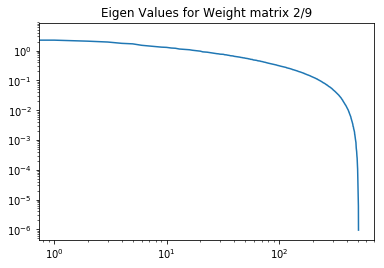

2019-03-25 11:24:04,095 INFO     Weight matrix 2/9 (512,512): Lognorm: 1.0120387077331543
2019-03-25 11:24:04,097 INFO     Weight matrix 3/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:05,934 INFO     Weight matrix 3/9 (512,512): Alpha: 3.1718407164184974, Alpha Weighted: 1.712986325324959, D: 0.07556437250749548


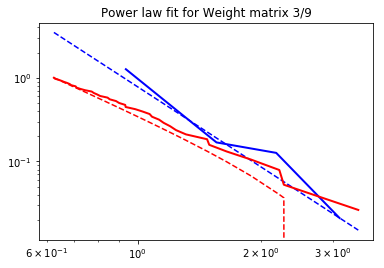

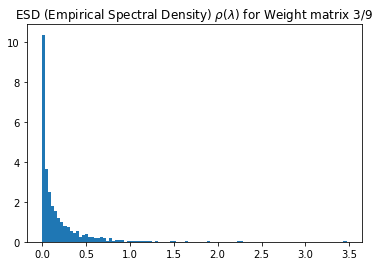

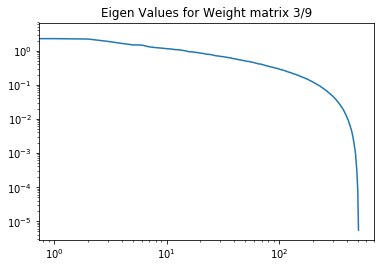

2019-03-25 11:24:07,259 INFO     Weight matrix 3/9 (512,512): Lognorm: 0.9953450560569763
2019-03-25 11:24:07,262 INFO     Weight matrix 4/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:09,071 INFO     Weight matrix 4/9 (512,512): Alpha: 3.8758790211199936, Alpha Weighted: 2.381268798382504, D: 0.07539074052471562
2019-03-25 11:24:09,073 INFO     Weight matrix 4/9 (512,512): Alpha 3.8758790211199936 is in the danger zone (1.5,3.5)


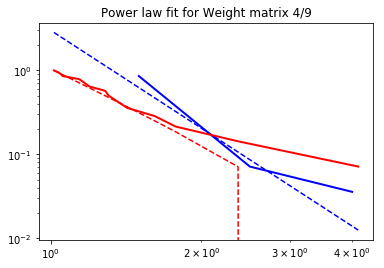

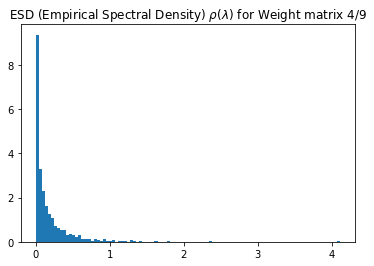

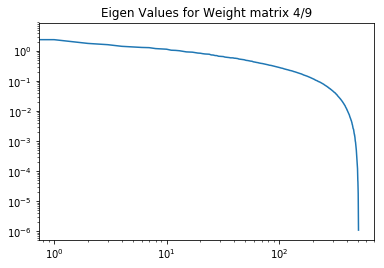

2019-03-25 11:24:10,615 INFO     Weight matrix 4/9 (512,512): Lognorm: 0.9894784092903137
2019-03-25 11:24:10,618 INFO     Weight matrix 5/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:12,261 INFO     Weight matrix 5/9 (512,512): Alpha: 2.2345612365861784, Alpha Weighted: 1.8784354715200198, D: 0.07883958577149847


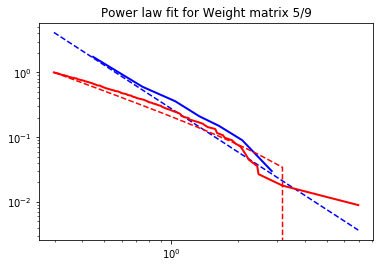

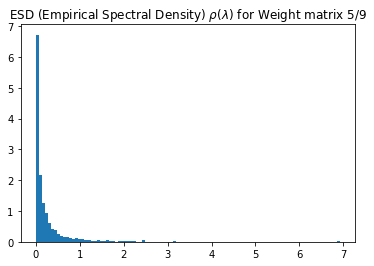

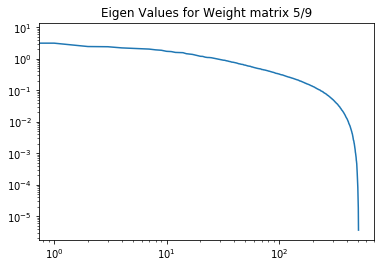

2019-03-25 11:24:13,654 INFO     Weight matrix 5/9 (512,512): Lognorm: 1.0499871969223022
2019-03-25 11:24:13,663 INFO     Weight matrix 6/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:15,435 INFO     Weight matrix 6/9 (512,512): Alpha: 3.2023205014173786, Alpha Weighted: 2.025716020243614, D: 0.07163783987476796


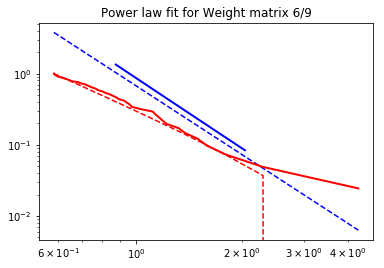

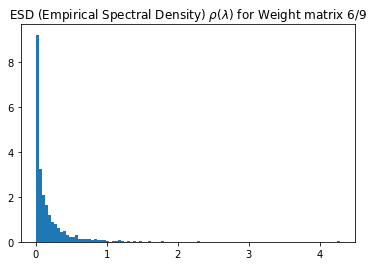

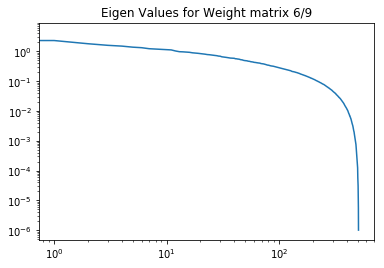

2019-03-25 11:24:16,688 INFO     Weight matrix 6/9 (512,512): Lognorm: 0.9896095395088196
2019-03-25 11:24:16,690 INFO     Weight matrix 7/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:18,459 INFO     Weight matrix 7/9 (512,512): Alpha: 2.8866023984147637, Alpha Weighted: 1.5256263769244889, D: 0.07947007401547695


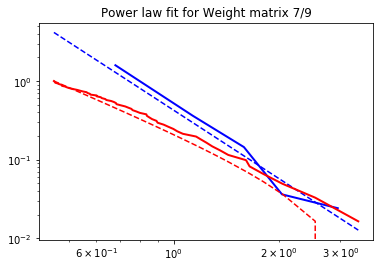

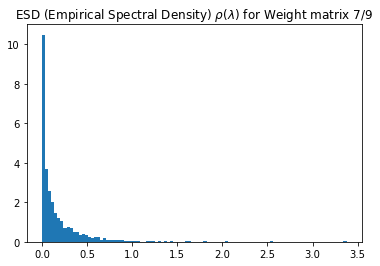

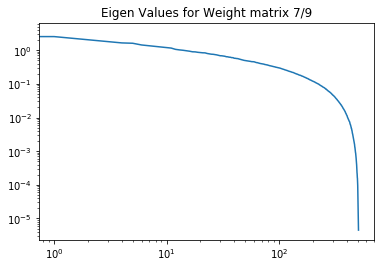

2019-03-25 11:24:19,805 INFO     Weight matrix 7/9 (512,512): Lognorm: 0.9956439137458801
2019-03-25 11:24:19,807 INFO     Weight matrix 8/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:21,536 INFO     Weight matrix 8/9 (512,512): Alpha: 2.9933245450843726, Alpha Weighted: 1.8340181125205381, D: 0.07260400848857052


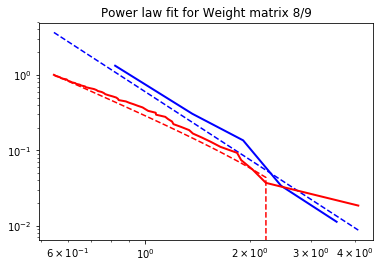

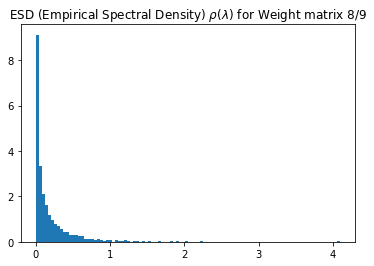

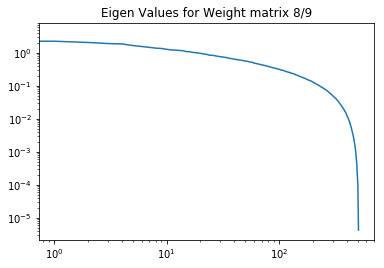

2019-03-25 11:24:22,810 INFO     Weight matrix 8/9 (512,512): Lognorm: 1.0118614435195923
2019-03-25 11:24:22,812 INFO     Weight matrix 9/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:24,546 INFO     Weight matrix 9/9 (512,512): Alpha: 2.9316359458426797, Alpha Weighted: 1.5953368796532965, D: 0.07331752590211105


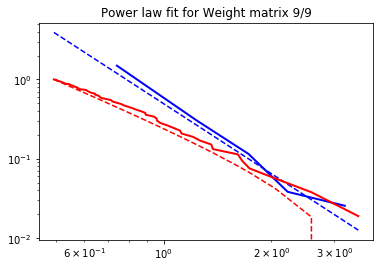

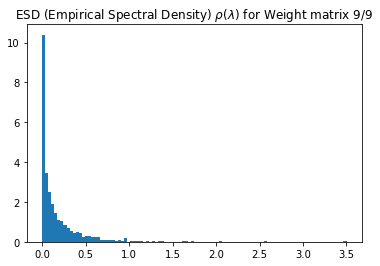

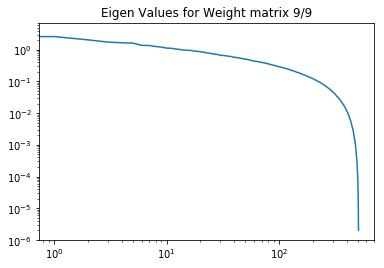

2019-03-25 11:24:25,972 INFO     Weight matrix 9/9 (512,512): Lognorm: 0.9950816631317139
2019-03-25 11:24:25,976 INFO Layer 20: ReLU(inplace)
2019-03-25 11:24:25,985 INFO Layer 20: Skipping (Layer not supported)
2019-03-25 11:24:25,987 INFO Layer 21: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2019-03-25 11:24:25,991 INFO Pytorch tensor shape detected: 512x512 (NxM), 3x3 (i,j)
2019-03-25 11:24:26,000 INFO Layer 21: Analyzing 9 weight matrices...
2019-03-25 11:24:26,006 INFO     Weight matrix 1/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:27,701 INFO     Weight matrix 1/9 (512,512): Alpha: 3.717476892026922, Alpha Weighted: 3.1915853222677004, D: 0.03975

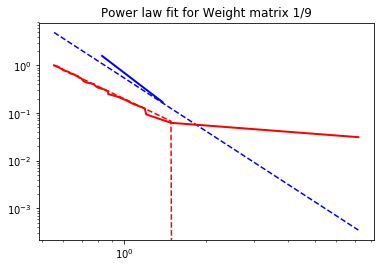

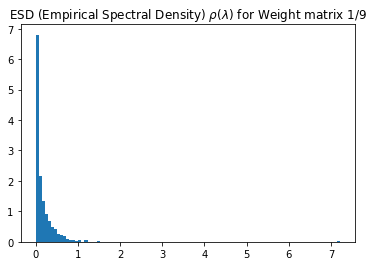

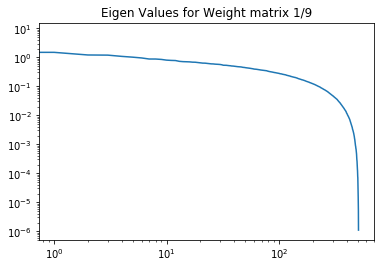

2019-03-25 11:24:29,138 INFO     Weight matrix 1/9 (512,512): Lognorm: 0.9724317193031311
2019-03-25 11:24:29,140 INFO     Weight matrix 2/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:31,002 INFO     Weight matrix 2/9 (512,512): Alpha: 3.654137644358388, Alpha Weighted: 3.643476159300835, D: 0.047044664377464795
2019-03-25 11:24:31,005 INFO     Weight matrix 2/9 (512,512): Alpha 3.654137644358388 is in the danger zone (1.5,3.5)


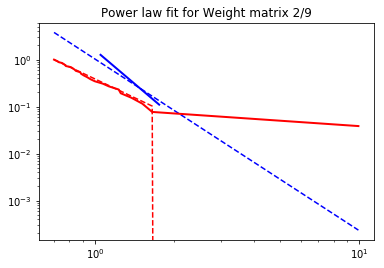

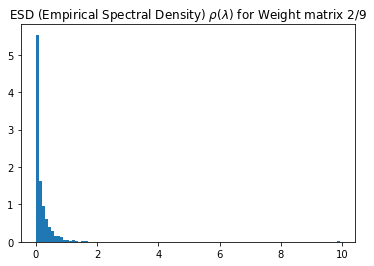

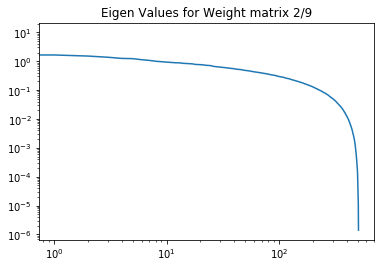

2019-03-25 11:24:32,318 INFO     Weight matrix 2/9 (512,512): Lognorm: 0.9977349042892456
2019-03-25 11:24:32,321 INFO     Weight matrix 3/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:34,062 INFO     Weight matrix 3/9 (512,512): Alpha: 3.738465181438594, Alpha Weighted: 3.3561857998379825, D: 0.03906598839629244
2019-03-25 11:24:34,069 INFO     Weight matrix 3/9 (512,512): Alpha 3.738465181438594 is in the danger zone (1.5,3.5)


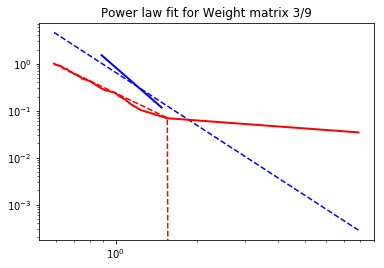

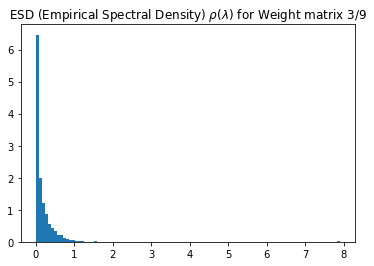

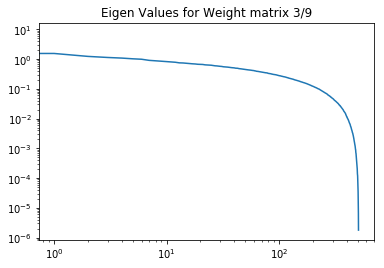

2019-03-25 11:24:35,549 INFO     Weight matrix 3/9 (512,512): Lognorm: 0.9764408469200134
2019-03-25 11:24:35,552 INFO     Weight matrix 4/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:37,327 INFO     Weight matrix 4/9 (512,512): Alpha: 3.515367115938416, Alpha Weighted: 3.288130902870324, D: 0.029411764705883137
2019-03-25 11:24:37,330 INFO     Weight matrix 4/9 (512,512): Alpha 3.515367115938416 is in the danger zone (1.5,3.5)


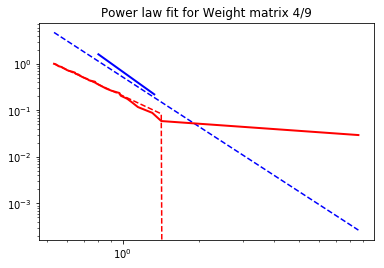

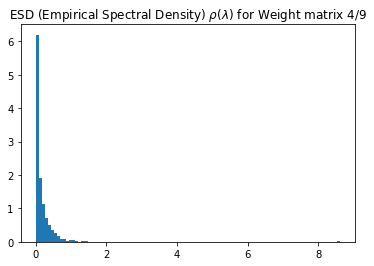

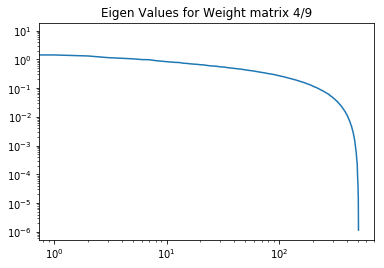

2019-03-25 11:24:38,644 INFO     Weight matrix 4/9 (512,512): Lognorm: 0.9728533029556274
2019-03-25 11:24:38,646 INFO     Weight matrix 5/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:40,473 INFO     Weight matrix 5/9 (512,512): Alpha: 2.775349742957407, Alpha Weighted: 2.983761813825438, D: 0.05535793872746175


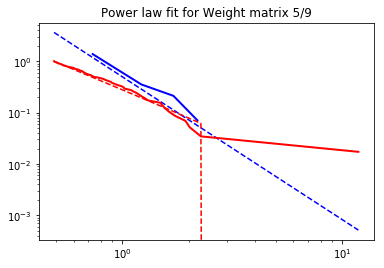

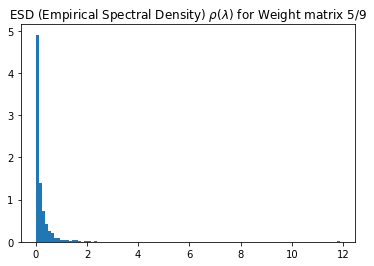

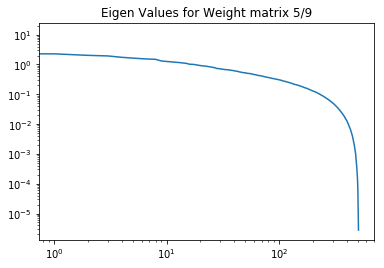

2019-03-25 11:24:41,892 INFO     Weight matrix 5/9 (512,512): Lognorm: 1.0238560438156128
2019-03-25 11:24:41,895 INFO     Weight matrix 6/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:43,655 INFO     Weight matrix 6/9 (512,512): Alpha: 3.437669897776743, Alpha Weighted: 3.236646762752945, D: 0.03492458751576355


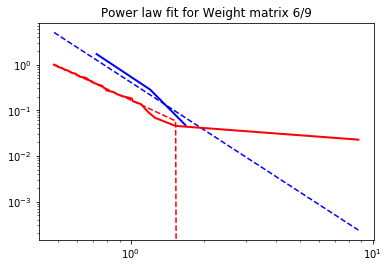

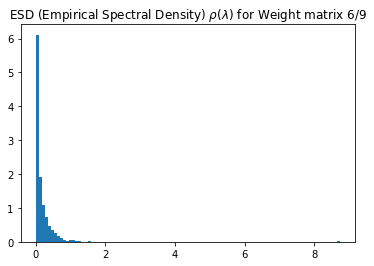

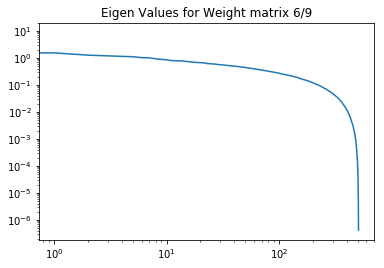

2019-03-25 11:24:45,163 INFO     Weight matrix 6/9 (512,512): Lognorm: 0.9753591418266296
2019-03-25 11:24:45,165 INFO     Weight matrix 7/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:46,920 INFO     Weight matrix 7/9 (512,512): Alpha: 3.785639449574037, Alpha Weighted: 3.20283425496509, D: 0.03172762482518798
2019-03-25 11:24:46,922 INFO     Weight matrix 7/9 (512,512): Alpha 3.785639449574037 is in the danger zone (1.5,3.5)


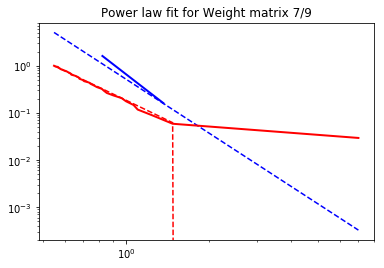

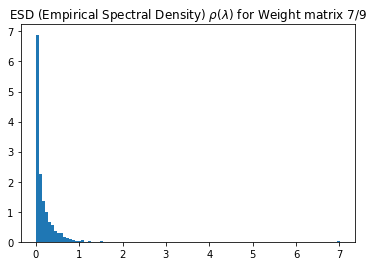

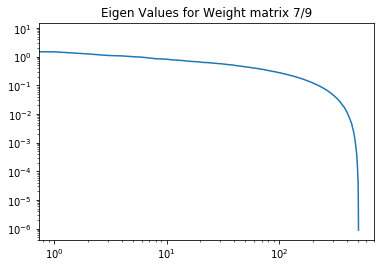

2019-03-25 11:24:48,260 INFO     Weight matrix 7/9 (512,512): Lognorm: 0.9722591042518616
2019-03-25 11:24:48,262 INFO     Weight matrix 8/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:50,136 INFO     Weight matrix 8/9 (512,512): Alpha: 3.409715553680498, Alpha Weighted: 3.324839381863829, D: 0.04401277541204279


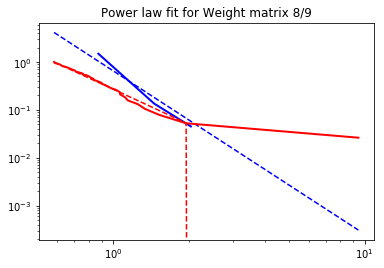

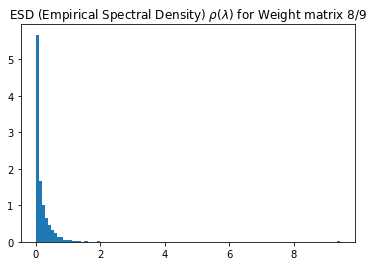

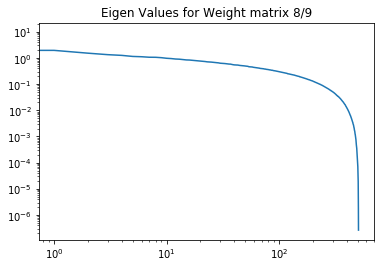

2019-03-25 11:24:51,492 INFO     Weight matrix 8/9 (512,512): Lognorm: 0.999003529548645
2019-03-25 11:24:51,494 INFO     Weight matrix 9/9 (512,512): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:24:53,303 INFO     Weight matrix 9/9 (512,512): Alpha: 3.6553010368391043, Alpha Weighted: 3.110291927839553, D: 0.03151278567057714
2019-03-25 11:24:53,311 INFO     Weight matrix 9/9 (512,512): Alpha 3.6553010368391043 is in the danger zone (1.5,3.5)


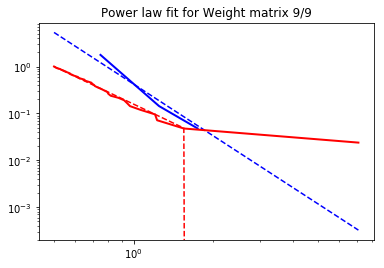

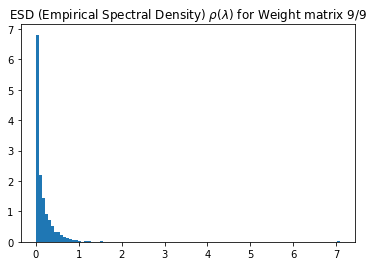

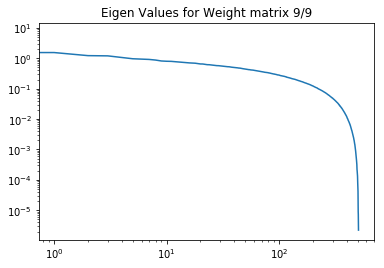

2019-03-25 11:24:54,639 INFO     Weight matrix 9/9 (512,512): Lognorm: 0.9731557369232178
2019-03-25 11:24:54,641 INFO Layer 22: ReLU(inplace)
2019-03-25 11:24:54,643 INFO Layer 22: Skipping (Layer not supported)
2019-03-25 11:24:54,645 INFO Layer 23: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2019-03-25 11:24:54,647 INFO Layer 23: Skipping (Layer not supported)
2019-03-25 11:24:54,647 INFO Layer 24: AdaptiveAvgPool2d(output_size=(7, 7))
2019-03-25 11:24:54,648 INFO Layer 24: Skipping (Layer not supported)
2019-03-25 11:24:54,648 INFO Layer 25: Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
2019-03-25 11:24:54,653 INFO Layer 25: Skipping (Layer not supported)
2019-03-25 11:24:54,654 INFO Layer 26: Linear(in_features=25

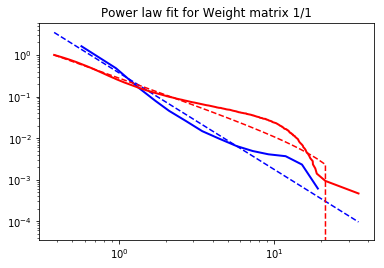

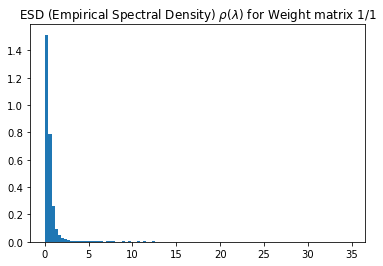

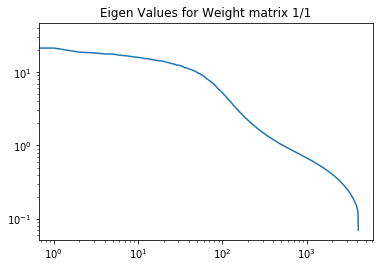

2019-03-25 11:32:34,334 INFO     Weight matrix 1/1 (4096,25088): Lognorm: 1.7582226991653442
2019-03-25 11:32:34,336 INFO Layer 27: ReLU(inplace)
2019-03-25 11:32:34,338 INFO Layer 27: Skipping (Layer not supported)
2019-03-25 11:32:34,340 INFO Layer 28: Dropout(p=0.5)
2019-03-25 11:32:34,342 INFO Layer 28: Skipping (Layer not supported)
2019-03-25 11:32:34,343 INFO Layer 29: Linear(in_features=4096, out_features=4096, bias=True)
2019-03-25 11:32:34,467 INFO Layer 29: Analyzing 1 weight matrices...
2019-03-25 11:32:34,474 INFO     Weight matrix 1/1 (4096,4096): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:34:49,995 INFO     Weight matrix 1/1 (4096,4096): Alpha: 2.167513528302566, Alpha Weighte

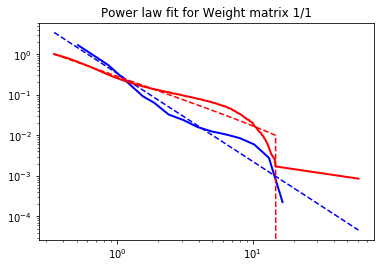

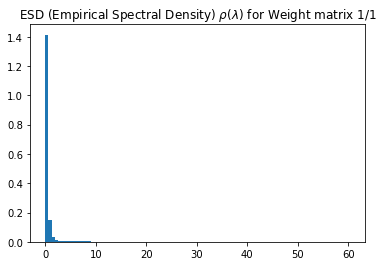

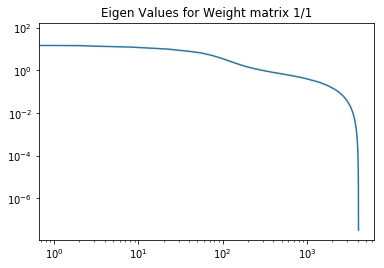

2019-03-25 11:34:51,207 INFO     Weight matrix 1/1 (4096,4096): Lognorm: 1.6415952444076538
2019-03-25 11:34:51,210 INFO Layer 30: ReLU(inplace)
2019-03-25 11:34:51,212 INFO Layer 30: Skipping (Layer not supported)
2019-03-25 11:34:51,214 INFO Layer 31: Dropout(p=0.5)
2019-03-25 11:34:51,214 INFO Layer 31: Skipping (Layer not supported)
2019-03-25 11:34:51,216 INFO Layer 32: Linear(in_features=4096, out_features=1000, bias=True)
2019-03-25 11:34:51,230 INFO Layer 32: Analyzing 1 weight matrices...
2019-03-25 11:34:51,233 INFO     Weight matrix 1/1 (1000,4096): Analyzing ...
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/conda/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
2019-03-25 11:34:59,854 INFO     Weight matrix 1/1 (1000,4096): Alpha: 2.825653827547283, Alpha Weighted

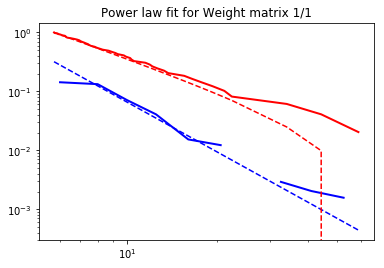

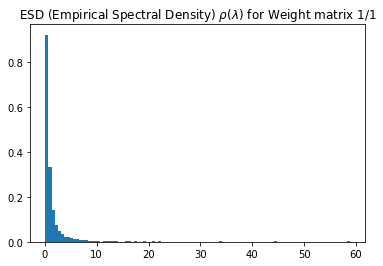

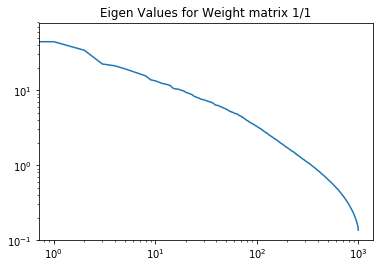

2019-03-25 11:35:01,406 INFO     Weight matrix 1/1 (1000,4096): Lognorm: 1.5924052000045776
2019-03-25 11:35:01,409 INFO ### Printing results ###
2019-03-25 11:35:01,411 DEBUG Layer 5: Lognorm compound: 0.7691774368286133
2019-03-25 11:35:01,414 DEBUG Layer 8: Lognorm compound: 0.8212912148899503
2019-03-25 11:35:01,416 DEBUG Layer 10: Lognorm compound: 0.8811508417129517
2019-03-25 11:35:01,417 DEBUG Layer 13: Lognorm compound: 0.9451767603556315
2019-03-25 11:35:01,418 DEBUG Layer 15: Lognorm compound: 0.9882696469624838
2019-03-25 11:35:01,418 DEBUG Layer 18: Lognorm compound: 1.0036969118648105
2019-03-25 11:35:01,419 DEBUG Layer 20: Lognorm compound: 0.9847882588704427
2019-03-25 11:35:01,419 DEBUG Layer 25: Lognorm: 1.7582226991653442
2019-03-25 11:35:01,420 DEBUG Layer 28: Lognorm: 1.6415952444076538
2019-03-25 11:35:01,421 DEBUG Layer 31: Lognorm: 1.5924052000045776
2019-03-25 11:35:01,423 INFO LogNorm: min: 0.7200042009353638, max: 1.7582226991653442, avg: 0.9474875926971436
2

In [14]:
import weightwatcher as ww
import torchvision.models as models

model = models.vgg11(pretrained=True)

watcher = ww.WeightWatcher(model=model)

results = watcher.analyze(compute_alphas=True, plot=True)

## Observations <a class="anchor" id="observations"></a>

In the GLEAMS model, we only have two layers with sufficient data points to generate a distribution that may be fit by a power law. The first, size (47, 32) seems to fit well and gives reasonable alpha:

`Weight matrix 1/1 (32,47): Alpha: 1.6028235390201724, Alpha Weighted: 0.790647329161501, D: 0.13927222035593628`

shape: (47, 32)


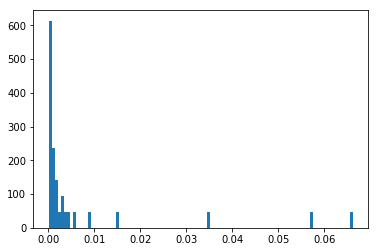

In [60]:
import numpy as np
import matplotlib.pyplot as plt


W = embedder_model.layers[3].get_weights()[0]
N, M = W.shape
print("shape: ({0:d}, {1:d})".format(N, M))

X = np.dot(W.T, W) / N
evals = np.linalg.eigvals(X)
plt.hist(evals, bins=100, density=True)
plt.show()

However, the second layer is much larger with size (44195, 32) and has a seemingly poor fit:

`Weight matrix 1/1 (32,44195): Alpha: 3.1674282241442517, Alpha Weighted: 8.949729335573819, D: 0.249844396998458`

shape: (44195, 32)


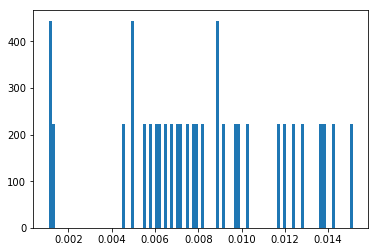

In [64]:
W = embedder_model.layers[16].get_weights()[0]
N, M = W.shape
print("shape: ({0:d}, {1:d})".format(N, M))

X = np.dot(W.T, W) / N
evals = np.linalg.eigvals(X)
plt.hist(evals, bins=100, density=True)
plt.show()

This poor fit may be a factor of the large difference in m and n. I can dive back into the theory in order to try and understand whether failure in this case may be expected. The paper lists some counterexamples.

Alternatively, I could try to find other pretrained models with large differences in M and N for some layer and evaluate the results of analysis in those cases.

## Conclusion <a class="anchor" id="conclusion"></a>

The 17th layer of the GLEAMS model appears to have weights that don't follow a power law fit. Even if we grant that the fit may be appropriate, the resulting alpha is still far outside of the expected range, indicating violation of the empirical pattern. This may be indicative that the GLEAMS model is suboptimal.

However, maybe the alpha metric is simply not useful in this case. If we are to draw conclusions about the GLEAMS model we ought to try and apply the alpha metric to a similarly constructed embedder model as another control. Damon May's paper references several such examples in the introduction.